### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

from astrobf.morph import custom_morph
from astrobf.analysis import multi_clustering as mucl
from astrobf.analysis.multi_clustering import labeler

import time

import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

In [2]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [3]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

### Append Asym center to all_gals

In [4]:
asym_center = pickle.load(open("./mean_center_asym.pickle", "rb"))

for ag in all_gals:
    ind = np.where(asym_center['id'] == ag['img_name'])[0]
    ag.update({'asym_center':np.array((asym_center['xc_asym'][ind],
                                       asym_center['yc_asym'][ind])).squeeze()})


### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [5]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

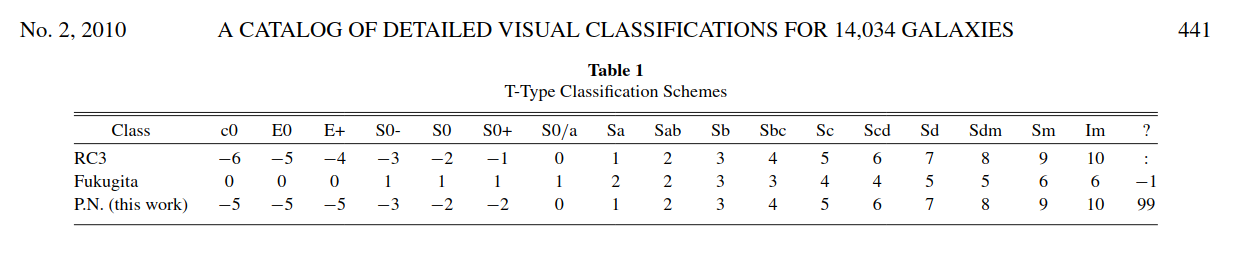

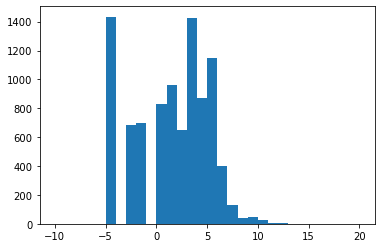

In [6]:
plt.hist(cat['TT'], range=[-10,20], bins=30)
plt.show()

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

In [6]:
## Runtime config.

fields = ['gini', 'm20', 'concentration']#'concentration']#, 'smoothness']
label_field = 'TT'

Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

class dataset():
    def __init__(self):

### Test evaluate

Need to be dl > dh ? 

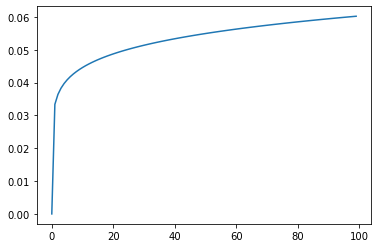

In [8]:
params = {'b0': 6.5994335621336555,
         'c0': 3.8522801643712445,
         'dl0': 13.850014672900969,
         'dh0': 1.0,
         'b1': 6.129207334451078,
         'c1': 1.207514275741114,
         'dl1': 13.0,
         'dh1': 2.0380281794991895,
         'b2': 6.5994335621336555,
         'c2': 3.8522801643712445,
         'dl2': 13.850014672900969,
         'dh2': 1.0,
         'b3': 6.129207334451078,
         'c3': 7.207514275741114,
         'dl3': 1.0,
         'dh3': 6.0380281794991895}

from astrobf.tmo import Mantiuk_Seidel
for i in [1]:
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(params, f"{i}")))

In [30]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS', debug=False, return_result=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(mucl.get_morph(sub_gals, 
                                          plist[i], 
                                          np.where(subcat['label'] == i)[0],
                                          fields)
                                          )
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
    #eval_metrics = do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                         fields=fields, 
                         cluster_method=cluster_method,
#                         eval_weight='area'
                         )
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    #clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    clustering_score = eval_metrics[0][0]
    print(clustering_score)
    stderr = 0.0
    if return_result:
        return result_arr, {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}
    else:
        return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

def evaluate_singleTM(params, cluster_method="agglomerate", eval_method='sample-weighted FMS', debug=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(1)]

    result_list = []
    for i in range(ngroups):
        result_list.append(mucl.get_morph(sub_gals, 
                                          plist[0], 
                                          np.where(subcat['label'] == i)[0],
                                          fields)
                                          )
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=fields, 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

# Test evaluate

In [10]:
params = {'b0': 6.5994335621336555,
         'c0': 3.8522801643712445,
         'dl0': 13.850014672900969,
         'dh0': 1.0,
         'b1': 6.129207334451078,
         'c1': 1.207514275741114,
         'dl1': 13.0,
         'dh1': 2.0380281794991895,
         'b2': 6.5994335621336555,
         'c2': 3.8522801643712445,
         'dl2': 13.850014672900969,
         'dh2': 1.0,
         'b3': 6.129207334451078,
         'c3': 7.207514275741114,
         'dl3': 1.0,
         'dh3': 6.0380281794991895}

ngroups = 4
this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin)
print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

# of sub sample: 7095


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



J004236.85m104922.04

In [11]:
plist = [{'b': 6.46, 'c': 5.72, 'dl': 2.9,  'dh': 1.48},
         {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45},
         {'b': 4.47, 'c': 5.77, 'dl': 10.24,'dh': 7.4},
         {'b': 7.91, 'c': 6.45, 'dl': 9.21, 'dh': 6.7}]

In [12]:
importlib.reload(mucl)
importlib.reload(custom_morph)

ag = all_gals[174]

plist =[{'b':params[f'b{i}'],
         'c':params[f'c{i}'],
        'dl':params[f'dl{i}'],
        'dh':params[f'dh{i}']} for i in range(ngroups)]
mi = custom_morph.MorphImg(ag, plist[0])
#plt.imshow(mi._tonemapped)

mi.measure_all()

1

In [31]:
importlib.reload(mucl)

# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'
suffix = 'concen'
#nTMs=1 

for ngroups in [2,4,6,8][1:]:
    this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
    nTMs = ngroups
    if nTMs == 1:
        eval_fn = evaluate_singleTM
    else:
        eval_fn = evaluate
    ax_params = mucl.gen_tmo_param_sets(nTMs)
    #ax_params = mucl.gen_tmo_param_sets(1)
        
    subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)
    #subcat = subcat

    print("# of sub sample: {}".format(len(subcat)))

    sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]
    
        
    for fn_result, cluster_method in zip([f"FMS_{ngroups}G_SVM_"+suffix,
                                          f"FMS_{ngroups}G_ward_"+suffix,
                                          f"FMS_{ngroups}G_agg_"+suffix,
                                          f"FMS_{ngroups}G_spec_"+suffix][:1],
                                         ['SVM', 'ward', 'agglomerate', 'spectral'][:1]):

        axc = AxClient()

        axc.create_experiment(
            parameters=ax_params,
            objective_name="mymetric",
            #minimize=True,  # Optional, defaults to False.
            parameter_constraints=[f"b{i} - dl{i} <= 100" for i in range(nTMs)] + \
                                  [f"dl{i} - dh{i} >= 0.1" for i in range(nTMs)], # all images are stretched to 100
            overwrite_existing_experiment =True,
            outcome_constraints=["total_flux >= 1e-5"],  # Optional.
        )

        all_metrics=[] # appended inside evaluate()
        for i in range(400):
            parameters, trial_index = axc.get_next_trial()
            axc.complete_trial(trial_index=trial_index,
                               #raw_data=evaluate(parameters,
                               raw_data=eval_fn(parameters,
                                                 cluster_method=cluster_method))

            if i % 10 == 9:
                pickle.dump(all_metrics, open(exp_dir+fn_result+f"_all_metrics_{i}.pickle", "wb"))
        pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

        if True:
            axc.save_to_json_file(exp_dir+fn_result+".json")
        else:
            axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[INFO 07-01 08:11:37] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 07-01 08:11:37] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 16 trials, GPEI for subsequent trials]). Iterations after 16 will take longer to generate due to  model-fitting.
[INFO 07-01 08:11:37] ax.service.ax_client: Generated new trial 0 with parameters {'b0': 6.6, 'c0': 7.4, 'dl0': 9.49, 'dh0': 

# of sub sample: 9313


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:14:55] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:14:55] ax.service.ax_client: Generated new trial 1 with parameters {'b0': 5.24, 'c0': 5.42, 'dl0': 9.16, 'dh0': 2.08, 'b1': 2.63, 'c1': 5.76, 'dl1': 12.35, 'dh1': 3.17, 'b2': 7.91, 'c2': 1.85, 'dl2': 5.02, 'dh2': 3.8, 'b3': 3.62, 'c3': 4.66, 'dl3': 10.03, 'dh3': 8.15}.


0.581565481032


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 08:16:42] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 07-01 08:16:42] ax.service.ax_client: Generated new trial 2 with parameters {'b0': 5.36, 'c0': 6.52, 'dl0': 14.12, 'dh0': 2.97, 'b1': 7.45, 'c1': 4.0, 'dl1': 11.53, 'dh1': 5.05, 'b2': 3.99, 'c2': 5.47, 'dl2': 14.79, 'dh2': 5.53, 'b3': 6.29, 'c3': 7.43, 'dl3': 13.11, 'dh3': 6.61}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000047.89p141639.09


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:20:03] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.45000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:20:03] ax.service.ax_client: Generated new trial 3 with parameters {'b0': 4.06, 'c0': 6.13, 'dl0': 8.61, 'dh0': 6.92, 'b1': 2.86, 'c1': 5.84, 'dl1': 13.4, 'dh1': 3.19, 'b2': 4.01, 'c2': 2.88, 'dl2': 8.85, 'dh2': 6.21, 'b3': 7.51, 'c3': 7.56, 'dl3': 9.41, 'dh3': 6.51}.


0.44964852339


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:23:22] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:23:23] ax.service.ax_client: Generated new trial 4 with parameters {'b0': 2.41, 'c0': 3.5, 'dl0': 10.76, 'dh0': 10.63, 'b1': 5.54, 'c1': 6.67, 'dl1': 9.82, 'dh1': 5.28, 'b2': 7.61, 'c2': 5.15, 'dl2': 14.03, 'dh2': 11.69, 'b3': 6.31, 'c3': 5.89, 'dl3': 14.33, 'dh3': 9.69}.


0.468126503834


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:26:43] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:26:43] ax.service.ax_client: Generated new trial 5 with parameters {'b0': 1.98, 'c0': 3.85, 'dl0': 14.54, 'dh0': 12.2, 'b1': 7.5, 'c1': 2.6, 'dl1': 3.91, 'dh1': 2.86, 'b2': 2.8, 'c2': 4.91, 'dl2': 10.82, 'dh2': 6.76, 'b3': 4.37, 'c3': 3.78, 'dl3': 7.71, 'dh3': 5.63}.


0.651992534978


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 08:27:39] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 07-01 08:27:39] ax.service.ax_client: Generated new trial 6 with parameters {'b0': 3.47, 'c0': 3.88, 'dl0': 14.09, 'dh0': 2.04, 'b1': 6.08, 'c1': 3.13, 'dl1': 13.11, 'dh1': 6.64, 'b2': 6.91, 'c2': 4.32, 'dl2': 14.73, 'dh2': 12.48, 'b3': 5.29, 'c3': 1.83, 'dl3': 14.61, 'dh3': 13.14}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:31:01] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:31:01] ax.service.ax_client: Generated new trial 7 with parameters {'b0': 7.52, 'c0': 1.66, 'dl0': 6.41, 'dh0': 6.22, 'b1': 7.95, 'c1': 3.47, 'dl1': 11.76, 'dh1': 4.59, 'b2': 5.42, 'c2': 7.92, 'dl2': 5.74, 'dh2': 4.66, 'b3': 7.47, 'c3': 5.1, 'dl3': 4.65, 'dh3': 4.17}.


0.526141737004


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 08:33:29] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 07-01 08:33:29] ax.service.ax_client: Generated new trial 8 with parameters {'b0': 5.76, 'c0': 7.79, 'dl0': 13.94, 'dh0': 12.59, 'b1': 6.04, 'c1': 1.94, 'dl1': 7.23, 'dh1': 5.5, 'b2': 4.06, 'c2': 1.89, 'dl2': 4.85, 'dh2': 3.89, 'b3': 2.69, 'c3': 7.92, 'dl3': 8.39, 'dh3': 3.16}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000133.95p150453.64


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:36:45] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:36:45] ax.service.ax_client: Generated new trial 9 with parameters {'b0': 4.43, 'c0': 1.68, 'dl0': 11.9, 'dh0': 10.19, 'b1': 3.51, 'c1': 7.24, 'dl1': 13.65, 'dh1': 6.88, 'b2': 7.78, 'c2': 6.0, 'dl2': 14.21, 'dh2': 2.71, 'b3': 5.79, 'c3': 6.44, 'dl3': 14.43, 'dh3': 6.46}.


0.745187443497


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:40:09] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.56000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:40:09] ax.service.ax_client: Generated new trial 10 with parameters {'b0': 5.26, 'c0': 7.9, 'dl0': 9.72, 'dh0': 4.0, 'b1': 3.37, 'c1': 6.64, 'dl1': 1.88, 'dh1': 1.2, 'b2': 5.19, 'c2': 6.53, 'dl2': 11.57, 'dh2': 4.83, 'b3': 4.65, 'c3': 2.82, 'dl3': 4.85, 'dh3': 1.44}.


0.558962671101


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:43:08] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:43:08] ax.service.ax_client: Generated new trial 11 with parameters {'b0': 7.52, 'c0': 2.29, 'dl0': 13.05, 'dh0': 7.52, 'b1': 2.96, 'c1': 5.16, 'dl1': 4.44, 'dh1': 3.37, 'b2': 2.91, 'c2': 5.04, 'dl2': 14.74, 'dh2': 9.01, 'b3': 7.85, 'c3': 4.65, 'dl3': 10.36, 'dh3': 3.85}.


0.946438505224


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:46:26] ax.service.ax_client: Completed trial 11 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:46:26] ax.service.ax_client: Generated new trial 12 with parameters {'b0': 6.76, 'c0': 1.55, 'dl0': 10.86, 'dh0': 1.03, 'b1': 2.39, 'c1': 4.86, 'dl1': 14.74, 'dh1': 11.39, 'b2': 3.77, 'c2': 3.55, 'dl2': 11.39, 'dh2': 5.39, 'b3': 4.21, 'c3': 7.17, 'dl3': 12.95, 'dh3': 12.17}.


0.692132359054


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:49:47] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:49:47] ax.service.ax_client: Generated new trial 13 with parameters {'b0': 3.81, 'c0': 4.79, 'dl0': 14.29, 'dh0': 9.87, 'b1': 7.61, 'c1': 7.9, 'dl1': 14.5, 'dh1': 10.42, 'b2': 4.03, 'c2': 5.0, 'dl2': 8.99, 'dh2': 2.82, 'b3': 2.91, 'c3': 4.66, 'dl3': 14.23, 'dh3': 12.53}.


0.593683447565


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:53:08] ax.service.ax_client: Completed trial 13 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:53:08] ax.service.ax_client: Generated new trial 14 with parameters {'b0': 6.71, 'c0': 6.77, 'dl0': 8.93, 'dh0': 6.93, 'b1': 2.46, 'c1': 1.99, 'dl1': 9.98, 'dh1': 2.51, 'b2': 3.04, 'c2': 7.66, 'dl2': 11.19, 'dh2': 5.29, 'b3': 1.65, 'c3': 7.2, 'dl3': 12.9, 'dh3': 1.88}.


0.610214800132


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:56:27] ax.service.ax_client: Completed trial 14 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 08:56:27] ax.service.ax_client: Generated new trial 15 with parameters {'b0': 7.95, 'c0': 3.14, 'dl0': 8.15, 'dh0': 4.48, 'b1': 3.27, 'c1': 6.93, 'dl1': 12.64, 'dh1': 4.19, 'b2': 7.73, 'c2': 5.99, 'dl2': 8.6, 'dh2': 1.53, 'b3': 4.16, 'c3': 2.52, 'dl3': 14.8, 'dh3': 10.33}.


0.730714119355


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 08:59:28] ax.service.ax_client: Completed trial 15 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.


0.882537127637


[INFO 07-01 08:59:33] ax.service.ax_client: Generated new trial 16 with parameters {'b0': 5.92, 'c0': 7.85, 'dl0': 9.59, 'dh0': 4.82, 'b1': 3.36, 'c1': 5.88, 'dl1': 3.07, 'dh1': 1.68, 'b2': 4.48, 'c2': 6.9, 'dl2': 12.37, 'dh2': 5.38, 'b3': 4.19, 'c3': 3.29, 'dl3': 6.31, 'dh3': 1.87}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or pe

Is every element matched?:  True


[INFO 07-01 09:02:36] ax.service.ax_client: Completed trial 16 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.


0.845243352511


[INFO 07-01 09:02:41] ax.service.ax_client: Generated new trial 17 with parameters {'b0': 5.89, 'c0': 7.08, 'dl0': 10.27, 'dh0': 4.29, 'b1': 2.91, 'c1': 6.91, 'dl1': 1.65, 'dh1': 1.46, 'b2': 4.82, 'c2': 6.54, 'dl2': 12.9, 'dh2': 5.6, 'b3': 5.54, 'c3': 3.02, 'dl3': 5.85, 'dh3': 1.41}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or pe

Is every element matched?:  True


[INFO 07-01 09:05:39] ax.service.ax_client: Completed trial 17 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.938114065967


[INFO 07-01 09:05:44] ax.service.ax_client: Generated new trial 18 with parameters {'b0': 5.92, 'c0': 7.57, 'dl0': 9.67, 'dh0': 4.34, 'b1': 3.17, 'c1': 7.24, 'dl1': 1.8, 'dh1': 1.53, 'b2': 5.26, 'c2': 7.27, 'dl2': 12.95, 'dh2': 4.54, 'b3': 4.63, 'c3': 2.14, 'dl3': 6.37, 'dh3': 2.28}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or pe

Is every element matched?:  True


[INFO 07-01 09:08:45] ax.service.ax_client: Completed trial 18 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.887340407481


[INFO 07-01 09:08:51] ax.service.ax_client: Generated new trial 19 with parameters {'b0': 5.3, 'c0': 7.95, 'dl0': 9.83, 'dh0': 3.99, 'b1': 2.43, 'c1': 6.89, 'dl1': 1.23, 'dh1': 1.0, 'b2': 5.0, 'c2': 7.34, 'dl2': 12.81, 'dh2': 4.33, 'b3': 4.93, 'c3': 3.65, 'dl3': 5.76, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 07-01 09:11:52] ax.service.ax_client: Completed trial 19 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.935914839304


[INFO 07-01 09:11:57] ax.service.ax_client: Generated new trial 20 with parameters {'b0': 5.73, 'c0': 7.98, 'dl0': 9.5, 'dh0': 3.58, 'b1': 3.09, 'c1': 7.18, 'dl1': 1.41, 'dh1': 1.12, 'b2': 4.73, 'c2': 6.87, 'dl2': 13.97, 'dh2': 6.56, 'b3': 4.55, 'c3': 3.09, 'dl3': 4.24, 'dh3': 1.07}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or pe

Is every element matched?:  True


[INFO 07-01 09:14:52] ax.service.ax_client: Completed trial 20 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.964815306356


[INFO 07-01 09:14:57] ax.service.ax_client: Generated new trial 21 with parameters {'b0': 5.97, 'c0': 7.82, 'dl0': 9.66, 'dh0': 4.17, 'b1': 2.27, 'c1': 6.71, 'dl1': 1.18, 'dh1': 1.03, 'b2': 4.26, 'c2': 6.94, 'dl2': 11.89, 'dh2': 5.07, 'b3': 4.8, 'c3': 2.41, 'dl3': 4.06, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 09:17:52] ax.service.ax_client: Completed trial 21 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.929981735852


[INFO 07-01 09:17:57] ax.service.ax_client: Generated new trial 22 with parameters {'b0': 5.76, 'c0': 8.0, 'dl0': 10.19, 'dh0': 2.53, 'b1': 2.9, 'c1': 6.0, 'dl1': 1.1, 'dh1': 1.0, 'b2': 5.14, 'c2': 7.07, 'dl2': 13.44, 'dh2': 5.87, 'b3': 5.2, 'c3': 2.54, 'dl3': 5.38, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 09:19:13] ax.service.ax_client: Completed trial 22 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[asymmetry_function] Zero flux sum.
ERROR in 1445-th galaxy J123117.11p465208.38


[INFO 07-01 09:19:19] ax.service.ax_client: Generated new trial 23 with parameters {'b0': 5.59, 'c0': 7.94, 'dl0': 9.35, 'dh0': 4.18, 'b1': 3.13, 'c1': 7.36, 'dl1': 1.72, 'dh1': 1.21, 'b2': 4.63, 'c2': 6.77, 'dl2': 13.5, 'dh2': 6.22, 'b3': 4.37, 'c3': 3.4, 'dl3': 4.24, 'dh3': 1.16}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or per

Is every element matched?:  True


[INFO 07-01 09:22:17] ax.service.ax_client: Completed trial 23 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.962534207286


[INFO 07-01 09:22:23] ax.service.ax_client: Generated new trial 24 with parameters {'b0': 6.05, 'c0': 7.62, 'dl0': 9.29, 'dh0': 4.04, 'b1': 3.24, 'c1': 6.68, 'dl1': 2.45, 'dh1': 1.0, 'b2': 4.55, 'c2': 7.12, 'dl2': 13.8, 'dh2': 5.48, 'b3': 4.55, 'c3': 3.06, 'dl3': 5.16, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perf

Is every element matched?:  True


[INFO 07-01 09:25:25] ax.service.ax_client: Completed trial 24 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.957495081531


[INFO 07-01 09:25:30] ax.service.ax_client: Generated new trial 25 with parameters {'b0': 5.65, 'c0': 8.0, 'dl0': 10.33, 'dh0': 4.04, 'b1': 2.61, 'c1': 6.94, 'dl1': 1.35, 'dh1': 1.25, 'b2': 4.83, 'c2': 6.82, 'dl2': 13.05, 'dh2': 7.18, 'b3': 4.5, 'c3': 2.96, 'dl3': 5.48, 'dh3': 2.28}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or pe

Is every element matched?:  True


[INFO 07-01 09:28:29] ax.service.ax_client: Completed trial 25 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 09:28:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0


0.924843347828


[INFO 07-01 09:28:35] ax.service.ax_client: Generated new trial 26 with parameters {'b0': 5.65, 'c0': 8.0, 'dl0': 10.27, 'dh0': 4.04, 'b1': 2.6, 'c1': 6.95, 'dl1': 1.4, 'dh1': 1.3, 'b2': 4.81, 'c2': 6.81, 'dl2': 13.04, 'dh2': 7.17, 'b3': 4.5, 'c3': 2.96, 'dl3': 5.48, 'dh3': 2.32}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 07-01 09:31:33] ax.service.ax_client: Completed trial 26 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 07-01 09:31:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 26_0


0.926221326947


[INFO 07-01 09:31:39] ax.service.ax_client: Generated new trial 27 with parameters {'b0': 5.64, 'c0': 8.0, 'dl0': 10.31, 'dh0': 4.04, 'b1': 2.6, 'c1': 6.95, 'dl1': 1.39, 'dh1': 1.29, 'b2': 4.81, 'c2': 6.82, 'dl2': 13.04, 'dh2': 7.18, 'b3': 4.5, 'c3': 2.96, 'dl3': 5.49, 'dh3': 2.29}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or per

Is every element matched?:  True


[INFO 07-01 09:34:37] ax.service.ax_client: Completed trial 27 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.924554456065


[INFO 07-01 09:34:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 26_0
[INFO 07-01 09:34:43] ax.service.ax_client: Generated new trial 28 with parameters {'b0': 6.12, 'c0': 8.0, 'dl0': 9.22, 'dh0': 3.92, 'b1': 2.96, 'c1': 7.59, 'dl1': 1.2, 'dh1': 1.1, 'b2': 5.09, 'c2': 6.61, 'dl2': 13.25, 'dh2': 5.23, 'b3': 5.03, 'c3': 3.01, 'dl3': 4.23, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 09:35:56] ax.service.ax_client: Completed trial 28 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[asymmetry_function] Zero flux sum.
ERROR in 1445-th galaxy J123117.11p465208.38


[INFO 07-01 09:35:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0
[INFO 07-01 09:36:01] ax.service.ax_client: Generated new trial 29 with parameters {'b0': 7.79, 'c0': 4.01, 'dl0': 8.62, 'dh0': 4.8, 'b1': 2.99, 'c1': 7.2, 'dl1': 10.33, 'dh1': 3.71, 'b2': 7.04, 'c2': 6.54, 'dl2': 10.35, 'dh2': 1.98, 'b3': 4.13, 'c3': 2.33, 'dl3': 14.14, 'dh3': 9.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: 

Is every element matched?:  True


[INFO 07-01 09:39:16] ax.service.ax_client: Completed trial 29 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.


0.655244852229


[INFO 07-01 09:39:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0
[INFO 07-01 09:39:22] ax.service.ax_client: Generated new trial 30 with parameters {'b0': 5.67, 'c0': 8.0, 'dl0': 9.36, 'dh0': 3.91, 'b1': 2.88, 'c1': 7.63, 'dl1': 1.81, 'dh1': 1.71, 'b2': 4.85, 'c2': 6.73, 'dl2': 13.58, 'dh2': 5.2, 'b3': 5.13, 'c3': 2.83, 'dl3': 3.94, 'dh3': 1.04}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 09:42:13] ax.service.ax_client: Completed trial 30 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[asymmetry_function] Zero flux sum.
ERROR in 517-th galaxy J153305.61m013741.67


[INFO 07-01 09:42:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0, 30_0
[INFO 07-01 09:42:19] ax.service.ax_client: Generated new trial 31 with parameters {'b0': 5.76, 'c0': 8.0, 'dl0': 9.51, 'dh0': 3.9, 'b1': 2.99, 'c1': 7.65, 'dl1': 1.69, 'dh1': 1.59, 'b2': 4.81, 'c2': 6.78, 'dl2': 13.41, 'dh2': 5.22, 'b3': 5.13, 'c3': 2.87, 'dl3': 4.07, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:

Is every element matched?:  True


[INFO 07-01 09:45:08] ax.service.ax_client: Completed trial 31 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.936528598328


[INFO 07-01 09:45:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0, 30_0
[INFO 07-01 09:45:14] ax.service.ax_client: Generated new trial 32 with parameters {'b0': 5.36, 'c0': 6.9, 'dl0': 9.19, 'dh0': 3.91, 'b1': 2.83, 'c1': 7.26, 'dl1': 1.1, 'dh1': 1.0, 'b2': 4.83, 'c2': 6.88, 'dl2': 13.06, 'dh2': 5.89, 'b3': 4.14, 'c3': 3.1, 'dl3': 4.22, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 09:46:27] ax.service.ax_client: Completed trial 32 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[asymmetry_function] Zero flux sum.
ERROR in 1445-th galaxy J123117.11p465208.38


[INFO 07-01 09:46:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0, 30_0
[INFO 07-01 09:46:33] ax.service.ax_client: Generated new trial 33 with parameters {'b0': 6.11, 'c0': 7.8, 'dl0': 9.76, 'dh0': 4.45, 'b1': 3.35, 'c1': 6.69, 'dl1': 2.32, 'dh1': 1.21, 'b2': 4.69, 'c2': 6.88, 'dl2': 13.34, 'dh2': 5.11, 'b3': 5.07, 'c3': 3.0, 'dl3': 5.89, 'dh3': 1.39}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>

Is every element matched?:  True


[INFO 07-01 09:49:31] ax.service.ax_client: Completed trial 33 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.938838358911


[INFO 07-01 09:49:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0, 30_0
[INFO 07-01 09:49:36] ax.service.ax_client: Generated new trial 34 with parameters {'b0': 6.02, 'c0': 8.0, 'dl0': 9.17, 'dh0': 4.03, 'b1': 3.15, 'c1': 6.98, 'dl1': 2.5, 'dh1': 1.41, 'b2': 4.66, 'c2': 7.36, 'dl2': 13.52, 'dh2': 4.89, 'b3': 4.47, 'c3': 2.8, 'dl3': 5.05, 'dh3': 1.18}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:

Is every element matched?:  True


[INFO 07-01 09:52:35] ax.service.ax_client: Completed trial 34 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.961410587583


[INFO 07-01 09:52:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0, 30_0
[INFO 07-01 09:52:40] ax.service.ax_client: Generated new trial 35 with parameters {'b0': 5.92, 'c0': 7.37, 'dl0': 10.6, 'dh0': 4.5, 'b1': 2.6, 'c1': 6.89, 'dl1': 2.27, 'dh1': 2.04, 'b2': 4.85, 'c2': 6.67, 'dl2': 12.19, 'dh2': 5.03, 'b3': 5.78, 'c3': 2.9, 'dl3': 6.53, 'dh3': 1.91}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:

Is every element matched?:  True


[INFO 07-01 09:55:43] ax.service.ax_client: Completed trial 35 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.912968186776


[INFO 07-01 09:55:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 28_0, 25_0, 26_0, 30_0
[INFO 07-01 09:55:49] ax.service.ax_client: Generated new trial 36 with parameters {'b0': 5.87, 'c0': 7.9, 'dl0': 9.33, 'dh0': 4.02, 'b1': 3.14, 'c1': 6.84, 'dl1': 1.1, 'dh1': 1.0, 'b2': 4.64, 'c2': 6.54, 'dl2': 14.08, 'dh2': 5.57, 'b3': 4.72, 'c3': 3.19, 'dl3': 5.01, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 09:56:46] ax.service.ax_client: Completed trial 36 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


[INFO 07-01 09:56:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 28_0, 36_0, 26_0, 30_0
[INFO 07-01 09:56:52] ax.service.ax_client: Generated new trial 37 with parameters {'b0': 5.87, 'c0': 7.9, 'dl0': 9.35, 'dh0': 4.01, 'b1': 3.16, 'c1': 6.86, 'dl1': 1.1, 'dh1': 1.0, 'b2': 4.68, 'c2': 6.58, 'dl2': 14.08, 'dh2': 5.59, 'b3': 4.72, 'c3': 3.23, 'dl3': 4.94, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 09:57:50] ax.service.ax_client: Completed trial 37 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


[INFO 07-01 09:57:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 09:57:55] ax.service.ax_client: Generated new trial 38 with parameters {'b0': 5.85, 'c0': 7.9, 'dl0': 9.29, 'dh0': 4.02, 'b1': 3.13, 'c1': 6.83, 'dl1': 1.1, 'dh1': 1.0, 'b2': 4.66, 'c2': 6.53, 'dl2': 14.08, 'dh2': 5.55, 'b3': 4.73, 'c3': 3.2, 'dl3': 4.98, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 09:58:52] ax.service.ax_client: Completed trial 38 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


[INFO 07-01 09:58:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 09:58:58] ax.service.ax_client: Generated new trial 39 with parameters {'b0': 6.18, 'c0': 7.39, 'dl0': 10.82, 'dh0': 4.39, 'b1': 3.3, 'c1': 6.95, 'dl1': 1.1, 'dh1': 1.0, 'b2': 4.92, 'c2': 6.45, 'dl2': 14.67, 'dh2': 5.82, 'b3': 5.66, 'c3': 2.74, 'dl3': 5.46, 'dh3': 1.02}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 09:59:56] ax.service.ax_client: Completed trial 39 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


[INFO 07-01 09:59:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:00:02] ax.service.ax_client: Generated new trial 40 with parameters {'b0': 5.9, 'c0': 7.72, 'dl0': 9.55, 'dh0': 4.88, 'b1': 2.95, 'c1': 7.34, 'dl1': 2.62, 'dh1': 1.58, 'b2': 4.6, 'c2': 6.58, 'dl2': 12.44, 'dh2': 5.09, 'b3': 5.0, 'c3': 3.33, 'dl3': 5.48, 'dh3': 1.84}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 07-01 10:03:03] ax.service.ax_client: Completed trial 40 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.941915996443


[INFO 07-01 10:03:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:03:09] ax.service.ax_client: Generated new trial 41 with parameters {'b0': 5.76, 'c0': 7.26, 'dl0': 9.71, 'dh0': 4.45, 'b1': 3.07, 'c1': 6.74, 'dl1': 2.14, 'dh1': 1.62, 'b2': 4.74, 'c2': 6.82, 'dl2': 12.03, 'dh2': 5.1, 'b3': 5.34, 'c3': 3.2, 'dl3': 5.74, 'dh3': 1.28}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 10:06:10] ax.service.ax_client: Completed trial 41 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.939030949184


[INFO 07-01 10:06:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:06:15] ax.service.ax_client: Generated new trial 42 with parameters {'b0': 5.73, 'c0': 7.95, 'dl0': 9.4, 'dh0': 4.27, 'b1': 3.21, 'c1': 7.18, 'dl1': 1.95, 'dh1': 1.17, 'b2': 4.62, 'c2': 6.79, 'dl2': 12.99, 'dh2': 5.44, 'b3': 4.8, 'c3': 3.1, 'dl3': 4.87, 'dh3': 1.26}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 07-01 10:09:13] ax.service.ax_client: Completed trial 42 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.95851504513


[INFO 07-01 10:09:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:09:19] ax.service.ax_client: Generated new trial 43 with parameters {'b0': 6.15, 'c0': 7.67, 'dl0': 10.09, 'dh0': 4.37, 'b1': 2.36, 'c1': 6.81, 'dl1': 2.8, 'dh1': 1.93, 'b2': 4.97, 'c2': 6.97, 'dl2': 12.56, 'dh2': 4.58, 'b3': 4.97, 'c3': 2.93, 'dl3': 5.95, 'dh3': 1.99}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 10:12:30] ax.service.ax_client: Completed trial 43 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.917311314213


[INFO 07-01 10:12:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:12:36] ax.service.ax_client: Generated new trial 44 with parameters {'b0': 5.17, 'c0': 7.91, 'dl0': 10.44, 'dh0': 4.86, 'b1': 2.93, 'c1': 6.8, 'dl1': 1.1, 'dh1': 1.0, 'b2': 4.94, 'c2': 7.21, 'dl2': 11.91, 'dh2': 4.57, 'b3': 4.93, 'c3': 2.58, 'dl3': 6.26, 'dh3': 1.69}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 10:13:49] ax.service.ax_client: Completed trial 44 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[asymmetry_function] Zero flux sum.
ERROR in 1445-th galaxy J123117.11p465208.38


[INFO 07-01 10:13:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:13:55] ax.service.ax_client: Generated new trial 45 with parameters {'b0': 5.7, 'c0': 8.0, 'dl0': 9.6, 'dh0': 4.12, 'b1': 2.12, 'c1': 6.89, 'dl1': 1.33, 'dh1': 1.0, 'b2': 4.49, 'c2': 7.27, 'dl2': 12.38, 'dh2': 4.16, 'b3': 5.0, 'c3': 3.39, 'dl3': 4.8, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-

Is every element matched?:  True


[INFO 07-01 10:16:48] ax.service.ax_client: Completed trial 45 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.945520409949


[INFO 07-01 10:16:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:16:54] ax.service.ax_client: Generated new trial 46 with parameters {'b0': 5.48, 'c0': 8.0, 'dl0': 9.98, 'dh0': 3.69, 'b1': 2.22, 'c1': 6.77, 'dl1': 1.46, 'dh1': 1.12, 'b2': 4.95, 'c2': 7.38, 'dl2': 13.15, 'dh2': 5.3, 'b3': 4.85, 'c3': 3.82, 'dl3': 6.16, 'dh3': 1.43}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 10:19:53] ax.service.ax_client: Completed trial 46 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.908056774758


[INFO 07-01 10:19:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:19:58] ax.service.ax_client: Generated new trial 47 with parameters {'b0': 6.16, 'c0': 8.0, 'dl0': 9.73, 'dh0': 4.02, 'b1': 2.13, 'c1': 6.67, 'dl1': 1.45, 'dh1': 1.16, 'b2': 4.14, 'c2': 6.88, 'dl2': 12.06, 'dh2': 6.23, 'b3': 4.6, 'c3': 2.6, 'dl3': 4.15, 'dh3': 1.51}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 07-01 10:22:52] ax.service.ax_client: Completed trial 47 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.930590194597


[INFO 07-01 10:22:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:22:58] ax.service.ax_client: Generated new trial 48 with parameters {'b0': 5.63, 'c0': 7.87, 'dl0': 10.1, 'dh0': 4.35, 'b1': 2.37, 'c1': 7.4, 'dl1': 1.84, 'dh1': 1.71, 'b2': 4.76, 'c2': 6.62, 'dl2': 12.86, 'dh2': 7.59, 'b3': 4.29, 'c3': 3.43, 'dl3': 5.35, 'dh3': 2.61}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 07-01 10:25:57] ax.service.ax_client: Completed trial 48 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.92499698504


[INFO 07-01 10:25:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:26:03] ax.service.ax_client: Generated new trial 49 with parameters {'b0': 6.01, 'c0': 7.08, 'dl0': 10.27, 'dh0': 4.48, 'b1': 2.39, 'c1': 7.09, 'dl1': 2.6, 'dh1': 2.29, 'b2': 4.73, 'c2': 6.54, 'dl2': 11.89, 'dh2': 5.21, 'b3': 5.73, 'c3': 3.19, 'dl3': 6.5, 'dh3': 2.04}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 07-01 10:29:09] ax.service.ax_client: Completed trial 49 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.909502921655


[INFO 07-01 10:29:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:29:15] ax.service.ax_client: Generated new trial 50 with parameters {'b0': 6.12, 'c0': 7.33, 'dl0': 10.07, 'dh0': 4.53, 'b1': 2.4, 'c1': 7.34, 'dl1': 2.04, 'dh1': 1.79, 'b2': 4.72, 'c2': 6.36, 'dl2': 12.56, 'dh2': 5.38, 'b3': 5.25, 'c3': 3.03, 'dl3': 5.43, 'dh3': 1.81}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 10:32:18] ax.service.ax_client: Completed trial 50 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.938885526244


[INFO 07-01 10:32:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:32:24] ax.service.ax_client: Generated new trial 51 with parameters {'b0': 8.0, 'c0': 3.3, 'dl0': 8.34, 'dh0': 4.56, 'b1': 2.78, 'c1': 7.47, 'dl1': 12.38, 'dh1': 4.44, 'b2': 7.6, 'c2': 6.46, 'dl2': 10.46, 'dh2': 1.19, 'b3': 3.89, 'c3': 2.03, 'dl3': 14.83, 'dh3': 10.82}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 10:35:33] ax.service.ax_client: Completed trial 51 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.


0.649708333845


[INFO 07-01 10:35:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:35:39] ax.service.ax_client: Generated new trial 52 with parameters {'b0': 5.91, 'c0': 7.72, 'dl0': 9.81, 'dh0': 4.04, 'b1': 2.92, 'c1': 6.66, 'dl1': 2.37, 'dh1': 1.72, 'b2': 4.67, 'c2': 6.65, 'dl2': 12.6, 'dh2': 6.52, 'b3': 4.87, 'c3': 3.4, 'dl3': 6.04, 'dh3': 2.19}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 10:38:39] ax.service.ax_client: Completed trial 52 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.906884652794


[INFO 07-01 10:38:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:38:45] ax.service.ax_client: Generated new trial 53 with parameters {'b0': 5.56, 'c0': 7.99, 'dl0': 9.7, 'dh0': 4.3, 'b1': 2.43, 'c1': 7.37, 'dl1': 1.67, 'dh1': 1.51, 'b2': 5.15, 'c2': 7.16, 'dl2': 13.39, 'dh2': 4.57, 'b3': 4.45, 'c3': 3.37, 'dl3': 4.85, 'dh3': 1.1}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 07-01 10:41:44] ax.service.ax_client: Completed trial 53 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.956779535323


[INFO 07-01 10:41:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:41:49] ax.service.ax_client: Generated new trial 54 with parameters {'b0': 6.1, 'c0': 7.73, 'dl0': 9.51, 'dh0': 4.68, 'b1': 2.71, 'c1': 7.05, 'dl1': 2.13, 'dh1': 1.65, 'b2': 4.45, 'c2': 6.84, 'dl2': 11.65, 'dh2': 4.45, 'b3': 4.7, 'c3': 2.21, 'dl3': 3.96, 'dh3': 1.56}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 10:44:45] ax.service.ax_client: Completed trial 54 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.915015032304


[INFO 07-01 10:44:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:44:51] ax.service.ax_client: Generated new trial 55 with parameters {'b0': 7.88, 'c0': 3.38, 'dl0': 8.15, 'dh0': 4.58, 'b1': 3.75, 'c1': 6.4, 'dl1': 11.72, 'dh1': 3.55, 'b2': 7.58, 'c2': 5.71, 'dl2': 6.96, 'dh2': 2.16, 'b3': 4.49, 'c3': 3.04, 'dl3': 14.71, 'dh3': 9.01}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 10:47:33] ax.service.ax_client: Completed trial 55 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.


0.851406590423


[INFO 07-01 10:47:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:47:39] ax.service.ax_client: Generated new trial 56 with parameters {'b0': 4.67, 'c0': 8.0, 'dl0': 9.83, 'dh0': 3.94, 'b1': 2.7, 'c1': 7.08, 'dl1': 1.82, 'dh1': 1.16, 'b2': 4.55, 'c2': 7.25, 'dl2': 14.33, 'dh2': 7.03, 'b3': 4.17, 'c3': 2.81, 'dl3': 4.82, 'dh3': 1.76}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 10:50:38] ax.service.ax_client: Completed trial 56 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.944217237803


[INFO 07-01 10:50:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:50:44] ax.service.ax_client: Generated new trial 57 with parameters {'b0': 7.52, 'c0': 2.91, 'dl0': 8.06, 'dh0': 4.13, 'b1': 3.96, 'c1': 6.39, 'dl1': 11.99, 'dh1': 4.09, 'b2': 7.29, 'c2': 5.41, 'dl2': 8.99, 'dh2': 2.16, 'b3': 5.02, 'c3': 2.52, 'dl3': 14.92, 'dh3': 10.24}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 07-01 10:53:56] ax.service.ax_client: Completed trial 57 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.


0.849165460541


[INFO 07-01 10:53:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:54:02] ax.service.ax_client: Generated new trial 58 with parameters {'b0': 7.59, 'c0': 2.96, 'dl0': 8.19, 'dh0': 4.63, 'b1': 3.26, 'c1': 5.58, 'dl1': 12.4, 'dh1': 3.64, 'b2': 7.14, 'c2': 5.46, 'dl2': 8.53, 'dh2': 4.11, 'b3': 4.76, 'c3': 3.92, 'dl3': 14.82, 'dh3': 10.2}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 10:57:13] ax.service.ax_client: Completed trial 58 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.


0.873749658072


[INFO 07-01 10:57:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 10:57:19] ax.service.ax_client: Generated new trial 59 with parameters {'b0': 7.72, 'c0': 3.11, 'dl0': 8.22, 'dh0': 4.56, 'b1': 4.27, 'c1': 6.56, 'dl1': 12.36, 'dh1': 2.08, 'b2': 7.92, 'c2': 5.46, 'dl2': 7.71, 'dh2': 2.39, 'b3': 5.04, 'c3': 2.98, 'dl3': 14.5, 'dh3': 12.03}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 07-01 11:00:10] ax.service.ax_client: Completed trial 59 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.


0.838207014443


[INFO 07-01 11:00:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:00:16] ax.service.ax_client: Generated new trial 60 with parameters {'b0': 5.83, 'c0': 7.29, 'dl0': 10.25, 'dh0': 4.13, 'b1': 2.58, 'c1': 6.76, 'dl1': 2.07, 'dh1': 1.81, 'b2': 4.85, 'c2': 6.86, 'dl2': 11.92, 'dh2': 5.61, 'b3': 5.39, 'c3': 2.98, 'dl3': 6.15, 'dh3': 1.73}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 07-01 11:03:18] ax.service.ax_client: Completed trial 60 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.91867023025


[INFO 07-01 11:03:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:03:24] ax.service.ax_client: Generated new trial 61 with parameters {'b0': 5.42, 'c0': 7.79, 'dl0': 9.13, 'dh0': 4.35, 'b1': 2.65, 'c1': 7.26, 'dl1': 2.28, 'dh1': 2.18, 'b2': 5.16, 'c2': 6.87, 'dl2': 13.65, 'dh2': 4.71, 'b3': 3.32, 'c3': 3.15, 'dl3': 4.32, 'dh3': 1.36}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 11:06:26] ax.service.ax_client: Completed trial 61 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965007748549


[INFO 07-01 11:06:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:06:31] ax.service.ax_client: Generated new trial 62 with parameters {'b0': 5.46, 'c0': 7.57, 'dl0': 9.83, 'dh0': 4.42, 'b1': 3.42, 'c1': 7.21, 'dl1': 2.62, 'dh1': 2.08, 'b2': 3.91, 'c2': 6.84, 'dl2': 12.81, 'dh2': 6.06, 'b3': 4.17, 'c3': 2.13, 'dl3': 5.08, 'dh3': 2.04}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 11:09:30] ax.service.ax_client: Completed trial 62 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.


0.89825694229


[INFO 07-01 11:09:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:09:36] ax.service.ax_client: Generated new trial 63 with parameters {'b0': 5.7, 'c0': 7.75, 'dl0': 7.53, 'dh0': 4.47, 'b1': 2.66, 'c1': 6.99, 'dl1': 2.53, 'dh1': 1.0, 'b2': 5.2, 'c2': 7.53, 'dl2': 13.08, 'dh2': 6.84, 'b3': 4.86, 'c3': 2.93, 'dl3': 3.95, 'dh3': 2.53}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 07-01 11:12:34] ax.service.ax_client: Completed trial 63 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.963655165939


[INFO 07-01 11:12:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:12:40] ax.service.ax_client: Generated new trial 64 with parameters {'b0': 6.03, 'c0': 7.74, 'dl0': 10.42, 'dh0': 4.41, 'b1': 2.98, 'c1': 7.19, 'dl1': 2.45, 'dh1': 1.0, 'b2': 4.74, 'c2': 7.93, 'dl2': 12.71, 'dh2': 4.68, 'b3': 4.36, 'c3': 4.01, 'dl3': 3.01, 'dh3': 2.51}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 11:15:32] ax.service.ax_client: Completed trial 64 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[asymmetry_function] Zero flux sum.
ERROR in 517-th galaxy J153305.61m013741.67


[INFO 07-01 11:15:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:15:38] ax.service.ax_client: Generated new trial 65 with parameters {'b0': 5.78, 'c0': 8.0, 'dl0': 9.88, 'dh0': 3.93, 'b1': 2.61, 'c1': 6.84, 'dl1': 1.58, 'dh1': 1.41, 'b2': 4.73, 'c2': 6.67, 'dl2': 13.22, 'dh2': 7.08, 'b3': 4.66, 'c3': 3.17, 'dl3': 5.7, 'dh3': 2.02}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 11:18:36] ax.service.ax_client: Completed trial 65 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.92638393619


[INFO 07-01 11:18:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:18:42] ax.service.ax_client: Generated new trial 66 with parameters {'b0': 5.28, 'c0': 7.57, 'dl0': 8.03, 'dh0': 4.58, 'b1': 2.92, 'c1': 7.0, 'dl1': 2.49, 'dh1': 1.88, 'b2': 4.75, 'c2': 6.22, 'dl2': 12.8, 'dh2': 6.86, 'b3': 4.2, 'c3': 2.88, 'dl3': 5.75, 'dh3': 1.6}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-

Is every element matched?:  True


[INFO 07-01 11:21:43] ax.service.ax_client: Completed trial 66 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.90942095422


[INFO 07-01 11:21:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:21:49] ax.service.ax_client: Generated new trial 67 with parameters {'b0': 8.0, 'c0': 3.03, 'dl0': 8.09, 'dh0': 4.69, 'b1': 3.29, 'c1': 6.23, 'dl1': 12.28, 'dh1': 4.24, 'b2': 7.4, 'c2': 6.0, 'dl2': 8.1, 'dh2': 2.57, 'b3': 4.37, 'c3': 3.15, 'dl3': 15.0, 'dh3': 9.35}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-

Is every element matched?:  True


[INFO 07-01 11:24:48] ax.service.ax_client: Completed trial 67 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.892316600178


[INFO 07-01 11:24:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:24:54] ax.service.ax_client: Generated new trial 68 with parameters {'b0': 6.2, 'c0': 7.58, 'dl0': 8.96, 'dh0': 3.96, 'b1': 3.39, 'c1': 6.49, 'dl1': 2.76, 'dh1': 1.57, 'b2': 4.37, 'c2': 6.63, 'dl2': 12.97, 'dh2': 6.74, 'b3': 6.07, 'c3': 2.71, 'dl3': 5.13, 'dh3': 2.13}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 07-01 11:27:53] ax.service.ax_client: Completed trial 68 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.918009929453


[INFO 07-01 11:27:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:27:59] ax.service.ax_client: Generated new trial 69 with parameters {'b0': 6.14, 'c0': 8.0, 'dl0': 9.47, 'dh0': 4.32, 'b1': 1.87, 'c1': 6.88, 'dl1': 1.21, 'dh1': 1.09, 'b2': 3.92, 'c2': 6.99, 'dl2': 11.37, 'dh2': 4.6, 'b3': 4.76, 'c3': 2.27, 'dl3': 3.06, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 11:30:46] ax.service.ax_client: Completed trial 69 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[asymmetry_function] Zero flux sum.
ERROR in 152-th galaxy J093654.39p374130.73


[INFO 07-01 11:30:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:30:52] ax.service.ax_client: Generated new trial 70 with parameters {'b0': 5.72, 'c0': 7.83, 'dl0': 8.02, 'dh0': 4.42, 'b1': 2.25, 'c1': 6.76, 'dl1': 2.35, 'dh1': 1.53, 'b2': 4.9, 'c2': 6.98, 'dl2': 12.31, 'dh2': 5.75, 'b3': 4.63, 'c3': 2.41, 'dl3': 4.42, 'dh3': 1.81}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 07-01 11:33:57] ax.service.ax_client: Completed trial 70 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965983692607


[INFO 07-01 11:33:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:34:02] ax.service.ax_client: Generated new trial 71 with parameters {'b0': 7.72, 'c0': 3.28, 'dl0': 8.28, 'dh0': 4.64, 'b1': 3.63, 'c1': 6.31, 'dl1': 11.45, 'dh1': 3.66, 'b2': 7.17, 'c2': 5.94, 'dl2': 8.9, 'dh2': 2.76, 'b3': 4.72, 'c3': 2.96, 'dl3': 14.44, 'dh3': 9.57}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 11:37:19] ax.service.ax_client: Completed trial 71 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.


0.83979208069


[INFO 07-01 11:37:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:37:25] ax.service.ax_client: Generated new trial 72 with parameters {'b0': 6.11, 'c0': 7.25, 'dl0': 9.17, 'dh0': 4.28, 'b1': 3.1, 'c1': 7.3, 'dl1': 2.45, 'dh1': 1.52, 'b2': 4.78, 'c2': 6.93, 'dl2': 13.15, 'dh2': 4.47, 'b3': 4.96, 'c3': 3.08, 'dl3': 6.26, 'dh3': 1.9}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 07-01 11:40:26] ax.service.ax_client: Completed trial 72 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.915597876209


[INFO 07-01 11:40:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:40:33] ax.service.ax_client: Generated new trial 73 with parameters {'b0': 5.26, 'c0': 7.9, 'dl0': 9.36, 'dh0': 3.97, 'b1': 2.38, 'c1': 7.12, 'dl1': 2.03, 'dh1': 1.0, 'b2': 5.04, 'c2': 7.47, 'dl2': 13.08, 'dh2': 5.2, 'b3': 4.12, 'c3': 3.9, 'dl3': 5.48, 'dh3': 1.89}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-

Is every element matched?:  True


[INFO 07-01 11:43:38] ax.service.ax_client: Completed trial 73 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.932949805639


[INFO 07-01 11:43:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:43:44] ax.service.ax_client: Generated new trial 74 with parameters {'b0': 6.38, 'c0': 7.63, 'dl0': 9.19, 'dh0': 4.57, 'b1': 3.26, 'c1': 6.4, 'dl1': 3.15, 'dh1': 1.56, 'b2': 4.7, 'c2': 6.52, 'dl2': 12.96, 'dh2': 6.41, 'b3': 4.47, 'c3': 3.53, 'dl3': 5.31, 'dh3': 1.57}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 11:46:54] ax.service.ax_client: Completed trial 74 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.950660429449


[INFO 07-01 11:46:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:47:01] ax.service.ax_client: Generated new trial 75 with parameters {'b0': 5.54, 'c0': 8.0, 'dl0': 8.86, 'dh0': 3.99, 'b1': 2.81, 'c1': 6.86, 'dl1': 2.02, 'dh1': 1.53, 'b2': 5.3, 'c2': 7.34, 'dl2': 13.63, 'dh2': 6.93, 'b3': 4.34, 'c3': 2.58, 'dl3': 4.37, 'dh3': 1.82}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 07-01 11:50:04] ax.service.ax_client: Completed trial 75 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.979372860423


[INFO 07-01 11:50:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:50:10] ax.service.ax_client: Generated new trial 76 with parameters {'b0': 6.1, 'c0': 7.05, 'dl0': 10.12, 'dh0': 4.37, 'b1': 2.54, 'c1': 7.33, 'dl1': 2.12, 'dh1': 2.02, 'b2': 4.95, 'c2': 5.85, 'dl2': 12.43, 'dh2': 5.84, 'b3': 5.62, 'c3': 2.62, 'dl3': 6.01, 'dh3': 2.39}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 07-01 11:53:17] ax.service.ax_client: Completed trial 76 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.938707230828


[INFO 07-01 11:53:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:53:23] ax.service.ax_client: Generated new trial 77 with parameters {'b0': 6.04, 'c0': 7.73, 'dl0': 8.46, 'dh0': 4.72, 'b1': 3.04, 'c1': 7.76, 'dl1': 2.82, 'dh1': 1.55, 'b2': 5.25, 'c2': 7.06, 'dl2': 12.88, 'dh2': 5.59, 'b3': 5.17, 'c3': 2.73, 'dl3': 4.39, 'dh3': 2.62}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 11:56:27] ax.service.ax_client: Completed trial 77 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.936265911716


[INFO 07-01 11:56:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:56:33] ax.service.ax_client: Generated new trial 78 with parameters {'b0': 5.77, 'c0': 7.83, 'dl0': 8.78, 'dh0': 4.36, 'b1': 3.48, 'c1': 6.05, 'dl1': 2.79, 'dh1': 2.32, 'b2': 3.83, 'c2': 6.1, 'dl2': 13.19, 'dh2': 4.58, 'b3': 5.58, 'c3': 4.56, 'dl3': 5.14, 'dh3': 2.12}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipyth

Is every element matched?:  True


[INFO 07-01 11:59:32] ax.service.ax_client: Completed trial 78 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.942947748069


[INFO 07-01 11:59:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0
[INFO 07-01 11:59:39] ax.service.ax_client: Generated new trial 79 with parameters {'b0': 5.99, 'c0': 7.85, 'dl0': 10.18, 'dh0': 4.32, 'b1': 2.65, 'c1': 6.88, 'dl1': 1.76, 'dh1': 1.66, 'b2': 4.45, 'c2': 6.52, 'dl2': 11.8, 'dh2': 4.03, 'b3': 4.8, 'c3': 2.16, 'dl3': 4.38, 'dh3': 1.18}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipyth

Is every element matched?:  True


[INFO 07-01 12:02:37] ax.service.ax_client: Completed trial 79 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.925050184429


[INFO 07-01 12:02:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:02:43] ax.service.ax_client: Generated new trial 80 with parameters {'b0': 7.75, 'c0': 3.36, 'dl0': 8.31, 'dh0': 4.36, 'b1': 2.79, 'c1': 6.59, 'dl1': 11.82, 'dh1': 2.58, 'b2': 7.77, 'c2': 5.1, 'dl2': 8.42, 'dh2': 3.25, 'b3': 4.46, 'c3': 3.39, 'dl3': 15.0, 'dh3': 11.48}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True


[INFO 07-01 12:05:52] ax.service.ax_client: Completed trial 80 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.905267727678


[INFO 07-01 12:05:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:05:58] ax.service.ax_client: Generated new trial 81 with parameters {'b0': 6.0, 'c0': 7.85, 'dl0': 10.18, 'dh0': 4.33, 'b1': 2.63, 'c1': 6.84, 'dl1': 1.75, 'dh1': 1.65, 'b2': 4.47, 'c2': 6.52, 'dl2': 11.82, 'dh2': 3.91, 'b3': 4.78, 'c3': 2.1, 'dl3': 4.38, 'dh3': 1.21}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 12:08:57] ax.service.ax_client: Completed trial 81 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.925882126943


[INFO 07-01 12:08:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:09:03] ax.service.ax_client: Generated new trial 82 with parameters {'b0': 6.09, 'c0': 6.99, 'dl0': 10.1, 'dh0': 4.37, 'b1': 2.34, 'c1': 7.43, 'dl1': 2.04, 'dh1': 1.94, 'b2': 4.81, 'c2': 5.94, 'dl2': 12.37, 'dh2': 5.59, 'b3': 5.56, 'c3': 2.88, 'dl3': 5.98, 'dh3': 2.45}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True


[INFO 07-01 12:12:07] ax.service.ax_client: Completed trial 82 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.934422155553


[INFO 07-01 12:12:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:12:13] ax.service.ax_client: Generated new trial 83 with parameters {'b0': 6.99, 'c0': 3.46, 'dl0': 8.73, 'dh0': 4.5, 'b1': 4.6, 'c1': 6.08, 'dl1': 12.29, 'dh1': 3.39, 'b2': 7.03, 'c2': 5.65, 'dl2': 8.48, 'dh2': 2.49, 'b3': 4.93, 'c3': 2.97, 'dl3': 15.0, 'dh3': 10.03}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 12:15:37] ax.service.ax_client: Completed trial 83 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.


0.78687307409


[INFO 07-01 12:15:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:15:43] ax.service.ax_client: Generated new trial 84 with parameters {'b0': 5.13, 'c0': 8.0, 'dl0': 9.39, 'dh0': 3.92, 'b1': 2.19, 'c1': 7.36, 'dl1': 2.04, 'dh1': 1.94, 'b2': 4.53, 'c2': 6.54, 'dl2': 13.4, 'dh2': 5.64, 'b3': 4.25, 'c3': 3.68, 'dl3': 4.64, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<i

Is every element matched?:  True


[INFO 07-01 12:18:47] ax.service.ax_client: Completed trial 84 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.94413809638


[INFO 07-01 12:18:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:18:53] ax.service.ax_client: Generated new trial 85 with parameters {'b0': 5.77, 'c0': 7.65, 'dl0': 9.34, 'dh0': 4.28, 'b1': 2.69, 'c1': 7.27, 'dl1': 2.53, 'dh1': 2.25, 'b2': 4.26, 'c2': 6.62, 'dl2': 12.81, 'dh2': 5.1, 'b3': 5.24, 'c3': 3.55, 'dl3': 5.38, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True


[INFO 07-01 12:21:58] ax.service.ax_client: Completed trial 85 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.937451412279


[INFO 07-01 12:21:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:22:05] ax.service.ax_client: Generated new trial 86 with parameters {'b0': 5.14, 'c0': 7.88, 'dl0': 7.61, 'dh0': 4.34, 'b1': 2.92, 'c1': 6.4, 'dl1': 2.75, 'dh1': 1.0, 'b2': 4.47, 'c2': 7.18, 'dl2': 13.87, 'dh2': 5.67, 'b3': 4.57, 'c3': 3.71, 'dl3': 4.54, 'dh3': 2.44}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True


[INFO 07-01 12:25:09] ax.service.ax_client: Completed trial 86 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965685176139


[INFO 07-01 12:25:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:25:15] ax.service.ax_client: Generated new trial 87 with parameters {'b0': 6.14, 'c0': 7.66, 'dl0': 8.94, 'dh0': 4.34, 'b1': 3.29, 'c1': 6.26, 'dl1': 2.5, 'dh1': 1.01, 'b2': 4.69, 'c2': 6.6, 'dl2': 12.84, 'dh2': 4.4, 'b3': 4.63, 'c3': 3.14, 'dl3': 5.38, 'dh3': 4.17}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True


[INFO 07-01 12:28:21] ax.service.ax_client: Completed trial 87 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.956733872298


[INFO 07-01 12:28:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:28:27] ax.service.ax_client: Generated new trial 88 with parameters {'b0': 5.82, 'c0': 7.74, 'dl0': 7.94, 'dh0': 4.8, 'b1': 3.31, 'c1': 6.3, 'dl1': 2.27, 'dh1': 1.79, 'b2': 4.64, 'c2': 7.25, 'dl2': 12.27, 'dh2': 6.78, 'b3': 4.75, 'c3': 3.0, 'dl3': 4.27, 'dh3': 1.78}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True


[INFO 07-01 12:31:26] ax.service.ax_client: Completed trial 88 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.984941459021


[INFO 07-01 12:31:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:31:32] ax.service.ax_client: Generated new trial 89 with parameters {'b0': 5.1, 'c0': 8.0, 'dl0': 9.34, 'dh0': 3.87, 'b1': 2.66, 'c1': 7.14, 'dl1': 1.71, 'dh1': 1.61, 'b2': 4.61, 'c2': 6.55, 'dl2': 13.21, 'dh2': 5.44, 'b3': 3.98, 'c3': 3.5, 'dl3': 4.58, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 07-01 12:34:36] ax.service.ax_client: Completed trial 89 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.94832023382


[INFO 07-01 12:34:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:34:42] ax.service.ax_client: Generated new trial 90 with parameters {'b0': 5.06, 'c0': 8.0, 'dl0': 9.28, 'dh0': 3.9, 'b1': 2.63, 'c1': 7.58, 'dl1': 1.64, 'dh1': 1.54, 'b2': 4.56, 'c2': 6.66, 'dl2': 12.93, 'dh2': 5.5, 'b3': 3.78, 'c3': 3.31, 'dl3': 4.64, 'dh3': 1.01}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the

Is every element matched?:  True


[INFO 07-01 12:37:44] ax.service.ax_client: Completed trial 90 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.943411024589


[INFO 07-01 12:37:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:37:50] ax.service.ax_client: Generated new trial 91 with parameters {'b0': 5.3, 'c0': 7.89, 'dl0': 10.92, 'dh0': 4.15, 'b1': 2.8, 'c1': 5.69, 'dl1': 2.39, 'dh1': 1.07, 'b2': 4.93, 'c2': 6.94, 'dl2': 13.11, 'dh2': 6.08, 'b3': 4.69, 'c3': 3.84, 'dl3': 4.87, 'dh3': 1.22}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 12:41:00] ax.service.ax_client: Completed trial 91 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.931503469337


[INFO 07-01 12:41:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:41:06] ax.service.ax_client: Generated new trial 92 with parameters {'b0': 6.33, 'c0': 7.21, 'dl0': 10.81, 'dh0': 4.4, 'b1': 3.03, 'c1': 6.18, 'dl1': 2.4, 'dh1': 2.3, 'b2': 5.45, 'c2': 7.05, 'dl2': 12.83, 'dh2': 7.37, 'b3': 5.13, 'c3': 2.2, 'dl3': 6.24, 'dh3': 1.89}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the

Is every element matched?:  True


[INFO 07-01 12:44:12] ax.service.ax_client: Completed trial 92 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.913711172464


[INFO 07-01 12:44:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:44:19] ax.service.ax_client: Generated new trial 93 with parameters {'b0': 7.58, 'c0': 3.22, 'dl0': 6.12, 'dh0': 4.46, 'b1': 2.45, 'c1': 5.78, 'dl1': 11.99, 'dh1': 5.05, 'b2': 7.71, 'c2': 5.27, 'dl2': 8.07, 'dh2': 2.45, 'b3': 5.51, 'c3': 2.32, 'dl3': 14.75, 'dh3': 11.54}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 07-01 12:47:05] ax.service.ax_client: Completed trial 93 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.976531862018


[INFO 07-01 12:47:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:47:11] ax.service.ax_client: Generated new trial 94 with parameters {'b0': 5.61, 'c0': 7.96, 'dl0': 8.54, 'dh0': 4.21, 'b1': 3.03, 'c1': 6.99, 'dl1': 1.41, 'dh1': 1.0, 'b2': 5.12, 'c2': 7.56, 'dl2': 12.04, 'dh2': 6.22, 'b3': 5.28, 'c3': 2.7, 'dl3': 4.32, 'dh3': 1.7}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the

Is every element matched?:  True


[INFO 07-01 12:50:04] ax.service.ax_client: Completed trial 94 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.975358445433


[INFO 07-01 12:50:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:50:10] ax.service.ax_client: Generated new trial 95 with parameters {'b0': 6.56, 'c0': 7.55, 'dl0': 9.78, 'dh0': 4.8, 'b1': 3.33, 'c1': 6.87, 'dl1': 3.09, 'dh1': 2.39, 'b2': 3.82, 'c2': 6.25, 'dl2': 12.92, 'dh2': 6.61, 'b3': 5.59, 'c3': 3.32, 'dl3': 5.93, 'dh3': 3.37}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 12:53:14] ax.service.ax_client: Completed trial 95 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.921223612794


[INFO 07-01 12:53:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:53:21] ax.service.ax_client: Generated new trial 96 with parameters {'b0': 5.9, 'c0': 7.82, 'dl0': 7.49, 'dh0': 4.63, 'b1': 2.33, 'c1': 7.05, 'dl1': 2.29, 'dh1': 1.0, 'b2': 4.58, 'c2': 7.68, 'dl2': 13.27, 'dh2': 5.56, 'b3': 4.54, 'c3': 2.33, 'dl3': 4.22, 'dh3': 1.13}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in th

Is every element matched?:  True


[INFO 07-01 12:56:27] ax.service.ax_client: Completed trial 96 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.963767752472


[INFO 07-01 12:56:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:56:33] ax.service.ax_client: Generated new trial 97 with parameters {'b0': 6.29, 'c0': 7.82, 'dl0': 9.14, 'dh0': 4.51, 'b1': 4.62, 'c1': 7.35, 'dl1': 2.94, 'dh1': 2.84, 'b2': 5.54, 'c2': 6.84, 'dl2': 13.19, 'dh2': 5.36, 'b3': 4.48, 'c3': 3.16, 'dl3': 5.82, 'dh3': 2.46}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 12:59:34] ax.service.ax_client: Completed trial 97 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.935087570224


[INFO 07-01 12:59:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 12:59:41] ax.service.ax_client: Generated new trial 98 with parameters {'b0': 6.16, 'c0': 7.76, 'dl0': 8.48, 'dh0': 4.6, 'b1': 2.05, 'c1': 7.1, 'dl1': 2.07, 'dh1': 1.0, 'b2': 4.97, 'c2': 6.92, 'dl2': 12.37, 'dh2': 6.2, 'b3': 4.86, 'c3': 3.42, 'dl3': 4.31, 'dh3': 3.62}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the 

Is every element matched?:  True


[INFO 07-01 13:02:43] ax.service.ax_client: Completed trial 98 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.97418304483


[INFO 07-01 13:02:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:02:49] ax.service.ax_client: Generated new trial 99 with parameters {'b0': 6.42, 'c0': 7.67, 'dl0': 8.83, 'dh0': 3.98, 'b1': 2.57, 'c1': 7.24, 'dl1': 1.86, 'dh1': 1.76, 'b2': 5.71, 'c2': 7.65, 'dl2': 12.91, 'dh2': 4.26, 'b3': 4.71, 'c3': 3.15, 'dl3': 6.11, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 13:05:51] ax.service.ax_client: Completed trial 99 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.922413420155


[INFO 07-01 13:05:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:05:57] ax.service.ax_client: Generated new trial 100 with parameters {'b0': 5.65, 'c0': 7.88, 'dl0': 8.41, 'dh0': 4.39, 'b1': 4.06, 'c1': 6.02, 'dl1': 3.11, 'dh1': 1.0, 'b2': 3.94, 'c2': 7.63, 'dl2': 13.67, 'dh2': 6.05, 'b3': 4.95, 'c3': 2.99, 'dl3': 5.69, 'dh3': 2.04}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 13:08:57] ax.service.ax_client: Completed trial 100 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.943802355286


[INFO 07-01 13:08:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:09:03] ax.service.ax_client: Generated new trial 101 with parameters {'b0': 6.29, 'c0': 7.79, 'dl0': 6.61, 'dh0': 4.41, 'b1': 3.38, 'c1': 6.52, 'dl1': 2.42, 'dh1': 1.0, 'b2': 5.48, 'c2': 6.5, 'dl2': 12.86, 'dh2': 5.63, 'b3': 4.8, 'c3': 3.13, 'dl3': 4.24, 'dh3': 1.14}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in th

Is every element matched?:  True


[INFO 07-01 13:11:47] ax.service.ax_client: Completed trial 101 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.958017288125


[INFO 07-01 13:11:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:11:53] ax.service.ax_client: Generated new trial 102 with parameters {'b0': 6.08, 'c0': 7.79, 'dl0': 9.89, 'dh0': 4.59, 'b1': 3.96, 'c1': 6.73, 'dl1': 3.25, 'dh1': 1.0, 'b2': 4.0, 'c2': 5.89, 'dl2': 13.22, 'dh2': 3.52, 'b3': 4.01, 'c3': 2.9, 'dl3': 5.9, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the 

Is every element matched?:  True


[INFO 07-01 13:14:53] ax.service.ax_client: Completed trial 102 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.


0.849241661663


[INFO 07-01 13:14:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:14:59] ax.service.ax_client: Generated new trial 103 with parameters {'b0': 6.44, 'c0': 7.79, 'dl0': 8.42, 'dh0': 4.22, 'b1': 3.69, 'c1': 6.79, 'dl1': 2.53, 'dh1': 2.43, 'b2': 4.37, 'c2': 8.0, 'dl2': 13.36, 'dh2': 7.45, 'b3': 4.43, 'c3': 4.09, 'dl3': 4.87, 'dh3': 2.5}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 13:17:55] ax.service.ax_client: Completed trial 103 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.968234658203


[INFO 07-01 13:17:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:18:01] ax.service.ax_client: Generated new trial 104 with parameters {'b0': 7.73, 'c0': 3.16, 'dl0': 5.33, 'dh0': 4.44, 'b1': 3.54, 'c1': 6.91, 'dl1': 11.91, 'dh1': 5.34, 'b2': 7.93, 'c2': 4.38, 'dl2': 8.23, 'dh2': 2.12, 'b3': 4.23, 'c3': 3.77, 'dl3': 14.75, 'dh3': 10.2}.
[INFO 07-01 13:18:01] ax.service.ax_client: Completed trial 104 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000200.82p150132.23


[INFO 07-01 13:18:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:18:08] ax.service.ax_client: Generated new trial 105 with parameters {'b0': 7.64, 'c0': 3.21, 'dl0': 7.74, 'dh0': 4.45, 'b1': 2.03, 'c1': 5.35, 'dl1': 12.02, 'dh1': 3.98, 'b2': 7.52, 'c2': 5.95, 'dl2': 8.04, 'dh2': 2.93, 'b3': 5.82, 'c3': 1.84, 'dl3': 14.8, 'dh3': 11.81}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 07-01 13:21:06] ax.service.ax_client: Completed trial 105 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.964842076793


[INFO 07-01 13:21:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:21:13] ax.service.ax_client: Generated new trial 106 with parameters {'b0': 6.22, 'c0': 7.75, 'dl0': 9.26, 'dh0': 4.31, 'b1': 2.86, 'c1': 6.46, 'dl1': 1.82, 'dh1': 1.41, 'b2': 4.48, 'c2': 6.94, 'dl2': 11.94, 'dh2': 6.35, 'b3': 5.01, 'c3': 2.63, 'dl3': 4.42, 'dh3': 1.56}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 13:24:07] ax.service.ax_client: Completed trial 106 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.9545645843


[INFO 07-01 13:24:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:24:14] ax.service.ax_client: Generated new trial 107 with parameters {'b0': 7.43, 'c0': 3.26, 'dl0': 6.41, 'dh0': 4.54, 'b1': 2.44, 'c1': 5.47, 'dl1': 12.07, 'dh1': 5.0, 'b2': 7.56, 'c2': 5.69, 'dl2': 8.12, 'dh2': 2.31, 'b3': 6.07, 'c3': 1.71, 'dl3': 14.73, 'dh3': 12.02}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 07-01 13:27:03] ax.service.ax_client: Completed trial 107 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.975063668053


[INFO 07-01 13:27:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:27:09] ax.service.ax_client: Generated new trial 108 with parameters {'b0': 7.78, 'c0': 3.15, 'dl0': 8.63, 'dh0': 4.42, 'b1': 2.66, 'c1': 5.88, 'dl1': 12.06, 'dh1': 3.08, 'b2': 7.58, 'c2': 5.65, 'dl2': 8.14, 'dh2': 3.07, 'b3': 4.91, 'c3': 2.75, 'dl3': 14.8, 'dh3': 10.82}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 07-01 13:30:19] ax.service.ax_client: Completed trial 108 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.912847214571


[INFO 07-01 13:30:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:30:26] ax.service.ax_client: Generated new trial 109 with parameters {'b0': 7.72, 'c0': 3.21, 'dl0': 6.87, 'dh0': 4.36, 'b1': 2.03, 'c1': 5.63, 'dl1': 11.94, 'dh1': 4.36, 'b2': 7.58, 'c2': 5.68, 'dl2': 8.02, 'dh2': 3.32, 'b3': 5.5, 'c3': 2.37, 'dl3': 14.86, 'dh3': 11.81}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 07-01 13:33:14] ax.service.ax_client: Completed trial 109 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.980251202856


[INFO 07-01 13:33:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:33:21] ax.service.ax_client: Generated new trial 110 with parameters {'b0': 7.59, 'c0': 3.18, 'dl0': 7.5, 'dh0': 4.64, 'b1': 2.33, 'c1': 5.73, 'dl1': 11.96, 'dh1': 4.69, 'b2': 7.91, 'c2': 4.96, 'dl2': 8.14, 'dh2': 1.06, 'b3': 5.58, 'c3': 1.96, 'dl3': 14.76, 'dh3': 11.15}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 07-01 13:36:08] ax.service.ax_client: Completed trial 110 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.966287132116


[INFO 07-01 13:36:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:36:14] ax.service.ax_client: Generated new trial 111 with parameters {'b0': 5.77, 'c0': 7.88, 'dl0': 8.13, 'dh0': 4.52, 'b1': 3.29, 'c1': 6.59, 'dl1': 2.24, 'dh1': 2.14, 'b2': 5.15, 'c2': 7.0, 'dl2': 12.93, 'dh2': 3.27, 'b3': 4.43, 'c3': 3.07, 'dl3': 4.29, 'dh3': 2.83}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 13:39:13] ax.service.ax_client: Completed trial 111 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.


0.989595028069


[INFO 07-01 13:39:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:39:20] ax.service.ax_client: Generated new trial 112 with parameters {'b0': 5.1, 'c0': 7.85, 'dl0': 9.24, 'dh0': 4.21, 'b1': 3.63, 'c1': 5.96, 'dl1': 2.57, 'dh1': 2.47, 'b2': 4.91, 'c2': 7.21, 'dl2': 13.46, 'dh2': 6.99, 'b3': 4.52, 'c3': 3.44, 'dl3': 5.15, 'dh3': 1.84}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 13:42:16] ax.service.ax_client: Completed trial 112 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.955430408649


[INFO 07-01 13:42:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:42:22] ax.service.ax_client: Generated new trial 113 with parameters {'b0': 7.62, 'c0': 3.02, 'dl0': 6.98, 'dh0': 4.52, 'b1': 2.85, 'c1': 5.14, 'dl1': 12.34, 'dh1': 4.54, 'b2': 7.37, 'c2': 5.9, 'dl2': 8.02, 'dh2': 3.0, 'b3': 5.36, 'c3': 1.93, 'dl3': 14.55, 'dh3': 9.97}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 13:45:15] ax.service.ax_client: Completed trial 113 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.952878061825


[INFO 07-01 13:45:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:45:21] ax.service.ax_client: Generated new trial 114 with parameters {'b0': 6.3, 'c0': 7.65, 'dl0': 8.97, 'dh0': 4.39, 'b1': 3.54, 'c1': 6.5, 'dl1': 2.93, 'dh1': 2.13, 'b2': 5.01, 'c2': 7.15, 'dl2': 13.28, 'dh2': 6.22, 'b3': 4.94, 'c3': 2.19, 'dl3': 6.46, 'dh3': 1.77}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 13:48:23] ax.service.ax_client: Completed trial 114 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.


0.900262203145


[INFO 07-01 13:48:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:48:29] ax.service.ax_client: Generated new trial 115 with parameters {'b0': 8.0, 'c0': 3.49, 'dl0': 8.27, 'dh0': 4.75, 'b1': 2.79, 'c1': 7.1, 'dl1': 11.58, 'dh1': 1.96, 'b2': 7.65, 'c2': 6.28, 'dl2': 8.05, 'dh2': 2.94, 'b3': 5.0, 'c3': 2.23, 'dl3': 14.9, 'dh3': 12.06}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 13:51:31] ax.service.ax_client: Completed trial 115 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.9353217549


[INFO 07-01 13:51:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:51:37] ax.service.ax_client: Generated new trial 116 with parameters {'b0': 5.79, 'c0': 7.76, 'dl0': 8.79, 'dh0': 4.83, 'b1': 2.75, 'c1': 7.26, 'dl1': 2.35, 'dh1': 1.0, 'b2': 5.08, 'c2': 6.48, 'dl2': 11.93, 'dh2': 4.6, 'b3': 3.83, 'c3': 2.65, 'dl3': 4.35, 'dh3': 1.11}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 07-01 13:54:38] ax.service.ax_client: Completed trial 116 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.967012736181


[INFO 07-01 13:54:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:54:45] ax.service.ax_client: Generated new trial 117 with parameters {'b0': 8.0, 'c0': 3.08, 'dl0': 7.98, 'dh0': 4.64, 'b1': 2.98, 'c1': 6.45, 'dl1': 12.29, 'dh1': 4.39, 'b2': 6.69, 'c2': 6.19, 'dl2': 8.5, 'dh2': 2.37, 'b3': 6.3, 'c3': 2.77, 'dl3': 14.79, 'dh3': 11.86}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 13:57:49] ax.service.ax_client: Completed trial 117 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.889201081627


[INFO 07-01 13:57:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 30_0, 79_0
[INFO 07-01 13:57:55] ax.service.ax_client: Generated new trial 118 with parameters {'b0': 6.36, 'c0': 7.91, 'dl0': 7.6, 'dh0': 4.56, 'b1': 2.58, 'c1': 6.99, 'dl1': 2.51, 'dh1': 2.41, 'b2': 5.17, 'c2': 6.92, 'dl2': 13.49, 'dh2': 8.07, 'b3': 4.19, 'c3': 3.47, 'dl3': 4.38, 'dh3': 2.07}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 07-01 14:00:58] ax.service.ax_client: Completed trial 118 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.954332129013


[INFO 07-01 14:00:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:01:05] ax.service.ax_client: Generated new trial 119 with parameters {'b0': 6.34, 'c0': 7.91, 'dl0': 7.6, 'dh0': 4.56, 'b1': 2.52, 'c1': 6.93, 'dl1': 2.51, 'dh1': 2.41, 'b2': 5.26, 'c2': 6.97, 'dl2': 13.48, 'dh2': 7.92, 'b3': 4.25, 'c3': 3.5, 'dl3': 4.37, 'dh3': 1.76}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 14:04:06] ax.service.ax_client: Completed trial 119 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.954026567111


[INFO 07-01 14:04:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:04:12] ax.service.ax_client: Generated new trial 120 with parameters {'b0': 8.0, 'c0': 3.35, 'dl0': 7.4, 'dh0': 4.52, 'b1': 3.19, 'c1': 5.28, 'dl1': 11.76, 'dh1': 4.07, 'b2': 8.0, 'c2': 6.12, 'dl2': 8.04, 'dh2': 1.0, 'b3': 4.83, 'c3': 2.12, 'dl3': 14.67, 'dh3': 12.95}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 14:06:55] ax.service.ax_client: Completed trial 120 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.928139257761


[INFO 07-01 14:06:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:07:02] ax.service.ax_client: Generated new trial 121 with parameters {'b0': 7.75, 'c0': 3.43, 'dl0': 7.08, 'dh0': 4.39, 'b1': 2.31, 'c1': 6.08, 'dl1': 11.81, 'dh1': 3.24, 'b2': 8.0, 'c2': 5.5, 'dl2': 7.96, 'dh2': 2.9, 'b3': 5.76, 'c3': 1.79, 'dl3': 14.57, 'dh3': 9.99}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 14:09:39] ax.service.ax_client: Completed trial 121 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.982275649261


[INFO 07-01 14:09:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:09:46] ax.service.ax_client: Generated new trial 122 with parameters {'b0': 6.51, 'c0': 3.26, 'dl0': 7.44, 'dh0': 4.58, 'b1': 2.56, 'c1': 6.21, 'dl1': 11.81, 'dh1': 4.3, 'b2': 8.0, 'c2': 5.84, 'dl2': 7.89, 'dh2': 4.64, 'b3': 5.22, 'c3': 1.99, 'dl3': 14.66, 'dh3': 11.81}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 07-01 14:12:47] ax.service.ax_client: Completed trial 122 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.962453865359


[INFO 07-01 14:12:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:12:53] ax.service.ax_client: Generated new trial 123 with parameters {'b0': 7.86, 'c0': 3.12, 'dl0': 9.65, 'dh0': 4.72, 'b1': 3.52, 'c1': 6.84, 'dl1': 11.98, 'dh1': 1.48, 'b2': 7.78, 'c2': 6.28, 'dl2': 8.84, 'dh2': 5.51, 'b3': 4.4, 'c3': 3.77, 'dl3': 15.0, 'dh3': 11.44}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 07-01 14:16:13] ax.service.ax_client: Completed trial 123 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.


0.816387050249


[INFO 07-01 14:16:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:16:19] ax.service.ax_client: Generated new trial 124 with parameters {'b0': 7.2, 'c0': 3.26, 'dl0': 7.12, 'dh0': 4.52, 'b1': 2.36, 'c1': 5.96, 'dl1': 11.98, 'dh1': 2.64, 'b2': 6.4, 'c2': 5.34, 'dl2': 8.1, 'dh2': 2.08, 'b3': 5.0, 'c3': 1.84, 'dl3': 14.69, 'dh3': 11.64}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 14:19:19] ax.service.ax_client: Completed trial 124 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.


0.899625257102


[INFO 07-01 14:19:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:19:26] ax.service.ax_client: Generated new trial 125 with parameters {'b0': 6.53, 'c0': 7.77, 'dl0': 7.92, 'dh0': 4.38, 'b1': 3.08, 'c1': 6.0, 'dl1': 2.75, 'dh1': 1.0, 'b2': 4.85, 'c2': 7.62, 'dl2': 13.14, 'dh2': 5.05, 'b3': 5.75, 'c3': 3.57, 'dl3': 4.59, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compariso

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:270: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 07-01 14:22:22] ax.service.ax_client: Completed trial 125 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[asymmetry_function] Zero flux sum.
ERROR in 517-th galaxy J153305.61m013741.67


[INFO 07-01 14:22:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:22:29] ax.service.ax_client: Generated new trial 126 with parameters {'b0': 5.02, 'c0': 7.89, 'dl0': 9.18, 'dh0': 3.98, 'b1': 3.79, 'c1': 6.44, 'dl1': 2.6, 'dh1': 2.12, 'b2': 3.2, 'c2': 5.83, 'dl2': 13.51, 'dh2': 5.59, 'b3': 4.8, 'c3': 4.42, 'dl3': 5.18, 'dh3': 3.07}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compariso

Is every element matched?:  True


[INFO 07-01 14:25:25] ax.service.ax_client: Completed trial 126 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.


0.89888281986


[INFO 07-01 14:25:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:25:32] ax.service.ax_client: Generated new trial 127 with parameters {'b0': 6.35, 'c0': 7.49, 'dl0': 9.32, 'dh0': 4.12, 'b1': 3.35, 'c1': 7.62, 'dl1': 2.24, 'dh1': 1.62, 'b2': 5.15, 'c2': 7.34, 'dl2': 13.98, 'dh2': 5.09, 'b3': 4.32, 'c3': 2.18, 'dl3': 6.23, 'dh3': 2.85}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 07-01 14:28:31] ax.service.ax_client: Completed trial 127 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.890772109613


[INFO 07-01 14:28:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:28:37] ax.service.ax_client: Generated new trial 128 with parameters {'b0': 5.55, 'c0': 7.54, 'dl0': 9.16, 'dh0': 3.9, 'b1': 3.83, 'c1': 7.23, 'dl1': 2.84, 'dh1': 1.96, 'b2': 4.07, 'c2': 5.88, 'dl2': 13.06, 'dh2': 7.58, 'b3': 5.61, 'c3': 2.45, 'dl3': 5.23, 'dh3': 3.22}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compari

Is every element matched?:  True


[INFO 07-01 14:31:34] ax.service.ax_client: Completed trial 128 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.946565993881


[INFO 07-01 14:31:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:31:40] ax.service.ax_client: Generated new trial 129 with parameters {'b0': 7.8, 'c0': 3.29, 'dl0': 7.19, 'dh0': 5.01, 'b1': 3.13, 'c1': 6.46, 'dl1': 11.98, 'dh1': 5.09, 'b2': 7.17, 'c2': 6.5, 'dl2': 7.14, 'dh2': 1.21, 'b3': 5.57, 'c3': 2.06, 'dl3': 14.57, 'dh3': 11.36}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 07-01 14:34:24] ax.service.ax_client: Completed trial 129 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.946170439315


[INFO 07-01 14:34:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:34:31] ax.service.ax_client: Generated new trial 130 with parameters {'b0': 5.4, 'c0': 8.0, 'dl0': 9.56, 'dh0': 4.1, 'b1': 2.1, 'c1': 7.07, 'dl1': 1.39, 'dh1': 1.05, 'b2': 4.61, 'c2': 7.35, 'dl2': 12.43, 'dh2': 4.97, 'b3': 4.67, 'c3': 4.04, 'dl3': 5.58, 'dh3': 1.62}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison

Is every element matched?:  True


[INFO 07-01 14:37:29] ax.service.ax_client: Completed trial 130 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.926489706718


[INFO 07-01 14:37:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:37:36] ax.service.ax_client: Generated new trial 131 with parameters {'b0': 5.43, 'c0': 7.77, 'dl0': 7.19, 'dh0': 4.66, 'b1': 3.62, 'c1': 7.82, 'dl1': 2.52, 'dh1': 1.11, 'b2': 5.12, 'c2': 7.0, 'dl2': 12.82, 'dh2': 7.08, 'b3': 4.56, 'c3': 2.6, 'dl3': 4.17, 'dh3': 2.98}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 14:40:30] ax.service.ax_client: Completed trial 131 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.


0.993341241039


[INFO 07-01 14:40:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:40:37] ax.service.ax_client: Generated new trial 132 with parameters {'b0': 5.79, 'c0': 7.8, 'dl0': 7.1, 'dh0': 4.6, 'b1': 4.01, 'c1': 6.78, 'dl1': 2.31, 'dh1': 1.62, 'b2': 4.68, 'c2': 6.48, 'dl2': 12.55, 'dh2': 7.86, 'b3': 4.35, 'c3': 3.01, 'dl3': 4.32, 'dh3': 2.8}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison

Is every element matched?:  True


[INFO 07-01 14:43:31] ax.service.ax_client: Completed trial 132 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.979891334175


[INFO 07-01 14:43:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:43:38] ax.service.ax_client: Generated new trial 133 with parameters {'b0': 5.82, 'c0': 7.47, 'dl0': 9.55, 'dh0': 4.15, 'b1': 3.41, 'c1': 6.49, 'dl1': 2.82, 'dh1': 1.6, 'b2': 4.09, 'c2': 6.16, 'dl2': 12.24, 'dh2': 6.88, 'b3': 6.02, 'c3': 3.05, 'dl3': 5.46, 'dh3': 3.08}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compari

Is every element matched?:  True


[INFO 07-01 14:46:37] ax.service.ax_client: Completed trial 133 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.908984934705


[INFO 07-01 14:46:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:46:44] ax.service.ax_client: Generated new trial 134 with parameters {'b0': 5.01, 'c0': 7.9, 'dl0': 8.17, 'dh0': 4.0, 'b1': 2.66, 'c1': 6.8, 'dl1': 2.64, 'dh1': 1.0, 'b2': 4.77, 'c2': 6.87, 'dl2': 13.58, 'dh2': 5.25, 'b3': 3.95, 'c3': 3.58, 'dl3': 4.69, 'dh3': 2.46}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison

Is every element matched?:  True


[INFO 07-01 14:49:52] ax.service.ax_client: Completed trial 134 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965170980847


[INFO 07-01 14:49:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:49:59] ax.service.ax_client: Generated new trial 135 with parameters {'b0': 7.6, 'c0': 3.23, 'dl0': 7.4, 'dh0': 4.64, 'b1': 2.69, 'c1': 6.62, 'dl1': 12.05, 'dh1': 4.62, 'b2': 7.92, 'c2': 5.86, 'dl2': 8.31, 'dh2': 1.04, 'b3': 5.5, 'c3': 1.61, 'dl3': 14.74, 'dh3': 11.51}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compari

Is every element matched?:  True


[INFO 07-01 14:52:51] ax.service.ax_client: Completed trial 135 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965504470409


[INFO 07-01 14:52:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:52:58] ax.service.ax_client: Generated new trial 136 with parameters {'b0': 5.95, 'c0': 7.9, 'dl0': 8.79, 'dh0': 4.31, 'b1': 3.77, 'c1': 7.03, 'dl1': 2.53, 'dh1': 1.8, 'b2': 3.6, 'c2': 7.6, 'dl2': 13.82, 'dh2': 7.61, 'b3': 3.89, 'c3': 3.97, 'dl3': 4.97, 'dh3': 2.68}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison

Is every element matched?:  True


[INFO 07-01 14:55:57] ax.service.ax_client: Completed trial 136 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.913261487547


[INFO 07-01 14:55:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:56:04] ax.service.ax_client: Generated new trial 137 with parameters {'b0': 5.38, 'c0': 8.0, 'dl0': 8.45, 'dh0': 4.99, 'b1': 2.48, 'c1': 7.58, 'dl1': 1.62, 'dh1': 1.0, 'b2': 4.67, 'c2': 6.87, 'dl2': 11.5, 'dh2': 5.4, 'b3': 4.8, 'c3': 2.92, 'dl3': 4.38, 'dh3': 1.98}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison 

Is every element matched?:  True


[INFO 07-01 14:59:03] ax.service.ax_client: Completed trial 137 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965894602293


[INFO 07-01 14:59:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 14:59:10] ax.service.ax_client: Generated new trial 138 with parameters {'b0': 5.95, 'c0': 7.99, 'dl0': 10.4, 'dh0': 3.29, 'b1': 2.64, 'c1': 6.42, 'dl1': 1.62, 'dh1': 1.24, 'b2': 4.75, 'c2': 7.37, 'dl2': 12.19, 'dh2': 5.28, 'b3': 3.81, 'c3': 3.12, 'dl3': 5.44, 'dh3': 1.95}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 07-01 15:02:11] ax.service.ax_client: Completed trial 138 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.893516230614


[INFO 07-01 15:02:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:02:18] ax.service.ax_client: Generated new trial 139 with parameters {'b0': 5.99, 'c0': 7.72, 'dl0': 12.9, 'dh0': 11.55, 'b1': 5.77, 'c1': 2.29, 'dl1': 7.34, 'dh1': 5.09, 'b2': 3.61, 'c2': 3.17, 'dl2': 6.8, 'dh2': 4.5, 'b3': 2.45, 'c3': 6.9, 'dl3': 8.46, 'dh3': 3.75}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compariso

Is every element matched?:  True


[INFO 07-01 15:05:38] ax.service.ax_client: Completed trial 139 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.


0.643076444071


[INFO 07-01 15:05:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:05:45] ax.service.ax_client: Generated new trial 140 with parameters {'b0': 5.84, 'c0': 7.06, 'dl0': 10.04, 'dh0': 4.02, 'b1': 2.45, 'c1': 7.23, 'dl1': 1.78, 'dh1': 1.68, 'b2': 4.8, 'c2': 6.7, 'dl2': 13.92, 'dh2': 5.08, 'b3': 5.43, 'c3': 3.66, 'dl3': 6.03, 'dh3': 1.31}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compari

Is every element matched?:  True


[INFO 07-01 15:08:46] ax.service.ax_client: Completed trial 140 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.940598704413


[INFO 07-01 15:08:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:08:53] ax.service.ax_client: Generated new trial 141 with parameters {'b0': 5.67, 'c0': 7.77, 'dl0': 9.47, 'dh0': 4.47, 'b1': 3.18, 'c1': 6.34, 'dl1': 2.81, 'dh1': 2.71, 'b2': 4.31, 'c2': 6.02, 'dl2': 13.81, 'dh2': 4.32, 'b3': 5.35, 'c3': 4.56, 'dl3': 5.66, 'dh3': 1.63}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 07-01 15:12:00] ax.service.ax_client: Completed trial 141 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.941828410104


[INFO 07-01 15:12:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:12:07] ax.service.ax_client: Generated new trial 142 with parameters {'b0': 5.53, 'c0': 7.75, 'dl0': 8.41, 'dh0': 4.23, 'b1': 2.78, 'c1': 7.43, 'dl1': 2.47, 'dh1': 1.0, 'b2': 5.09, 'c2': 6.3, 'dl2': 14.07, 'dh2': 6.27, 'b3': 4.59, 'c3': 3.01, 'dl3': 4.31, 'dh3': 2.25}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 15:15:09] ax.service.ax_client: Completed trial 142 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.960134714387


[INFO 07-01 15:15:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:15:16] ax.service.ax_client: Generated new trial 143 with parameters {'b0': 8.0, 'c0': 3.08, 'dl0': 9.8, 'dh0': 4.53, 'b1': 2.24, 'c1': 5.44, 'dl1': 12.51, 'dh1': 2.65, 'b2': 6.71, 'c2': 5.97, 'dl2': 8.1, 'dh2': 2.86, 'b3': 4.73, 'c3': 3.57, 'dl3': 14.94, 'dh3': 10.65}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compari

Is every element matched?:  True


[INFO 07-01 15:18:36] ax.service.ax_client: Completed trial 143 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.


0.813259679032


[INFO 07-01 15:18:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:18:43] ax.service.ax_client: Generated new trial 144 with parameters {'b0': 6.4, 'c0': 7.68, 'dl0': 9.35, 'dh0': 4.78, 'b1': 3.41, 'c1': 8.0, 'dl1': 2.49, 'dh1': 1.57, 'b2': 5.23, 'c2': 7.36, 'dl2': 11.36, 'dh2': 6.02, 'b3': 4.95, 'c3': 2.28, 'dl3': 4.44, 'dh3': 3.26}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 15:21:41] ax.service.ax_client: Completed trial 144 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.960144469986


[INFO 07-01 15:21:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:21:47] ax.service.ax_client: Generated new trial 145 with parameters {'b0': 6.57, 'c0': 7.47, 'dl0': 9.01, 'dh0': 4.48, 'b1': 3.1, 'c1': 6.84, 'dl1': 2.91, 'dh1': 2.65, 'b2': 4.07, 'c2': 7.01, 'dl2': 13.38, 'dh2': 6.4, 'b3': 5.95, 'c3': 2.36, 'dl3': 5.63, 'dh3': 1.51}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 15:24:52] ax.service.ax_client: Completed trial 145 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.940373349477


[INFO 07-01 15:24:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:24:59] ax.service.ax_client: Generated new trial 146 with parameters {'b0': 5.21, 'c0': 8.0, 'dl0': 8.6, 'dh0': 3.44, 'b1': 2.95, 'c1': 6.25, 'dl1': 1.92, 'dh1': 1.0, 'b2': 4.6, 'c2': 7.13, 'dl2': 12.2, 'dh2': 7.03, 'b3': 4.48, 'c3': 3.55, 'dl3': 4.59, 'dh3': 3.24}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison 

Is every element matched?:  True


[INFO 07-01 15:27:54] ax.service.ax_client: Completed trial 146 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.96784161571


[INFO 07-01 15:27:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:28:01] ax.service.ax_client: Generated new trial 147 with parameters {'b0': 6.02, 'c0': 7.24, 'dl0': 9.05, 'dh0': 4.7, 'b1': 3.25, 'c1': 7.08, 'dl1': 2.16, 'dh1': 2.06, 'b2': 5.54, 'c2': 7.16, 'dl2': 12.79, 'dh2': 3.65, 'b3': 4.9, 'c3': 2.22, 'dl3': 6.59, 'dh3': 1.26}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 07-01 15:31:00] ax.service.ax_client: Completed trial 147 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.892027445273


[INFO 07-01 15:31:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:31:07] ax.service.ax_client: Generated new trial 148 with parameters {'b0': 7.82, 'c0': 3.28, 'dl0': 6.77, 'dh0': 4.78, 'b1': 3.3, 'c1': 6.04, 'dl1': 12.11, 'dh1': 3.47, 'b2': 8.0, 'c2': 5.82, 'dl2': 10.84, 'dh2': 3.95, 'b3': 5.69, 'c3': 2.08, 'dl3': 14.62, 'dh3': 12.48}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwis

Is every element matched?:  True


[INFO 07-01 15:34:05] ax.service.ax_client: Completed trial 148 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.


0.653401977841


[INFO 07-01 15:34:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:34:12] ax.service.ax_client: Generated new trial 149 with parameters {'b0': 7.32, 'c0': 3.24, 'dl0': 6.4, 'dh0': 3.17, 'b1': 2.13, 'c1': 5.82, 'dl1': 11.99, 'dh1': 4.4, 'b2': 7.96, 'c2': 5.9, 'dl2': 5.28, 'dh2': 2.22, 'b3': 5.55, 'c3': 1.84, 'dl3': 14.81, 'dh3': 10.14}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 15:35:32] ax.service.ax_client: Completed trial 149 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000047.89p141639.09


[INFO 07-01 15:35:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:35:40] ax.service.ax_client: Generated new trial 150 with parameters {'b0': 5.4, 'c0': 7.71, 'dl0': 8.97, 'dh0': 4.88, 'b1': 2.83, 'c1': 7.76, 'dl1': 2.65, 'dh1': 2.55, 'b2': 4.76, 'c2': 6.49, 'dl2': 12.38, 'dh2': 5.95, 'b3': 4.83, 'c3': 2.81, 'dl3': 4.36, 'dh3': 2.34}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 07-01 15:38:42] ax.service.ax_client: Completed trial 150 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.924478146197


[INFO 07-01 15:38:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:38:49] ax.service.ax_client: Generated new trial 151 with parameters {'b0': 5.81, 'c0': 8.0, 'dl0': 9.82, 'dh0': 3.82, 'b1': 3.32, 'c1': 7.04, 'dl1': 1.69, 'dh1': 1.59, 'b2': 4.42, 'c2': 7.35, 'dl2': 12.45, 'dh2': 6.92, 'b3': 4.46, 'c3': 3.78, 'dl3': 4.82, 'dh3': 2.46}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 07-01 15:41:46] ax.service.ax_client: Completed trial 151 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.936022724358


[INFO 07-01 15:41:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:41:53] ax.service.ax_client: Generated new trial 152 with parameters {'b0': 5.12, 'c0': 8.0, 'dl0': 8.54, 'dh0': 4.11, 'b1': 2.85, 'c1': 6.99, 'dl1': 1.35, 'dh1': 1.0, 'b2': 4.52, 'c2': 6.85, 'dl2': 12.22, 'dh2': 6.19, 'b3': 4.9, 'c3': 2.6, 'dl3': 4.34, 'dh3': 1.43}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise com

Is every element matched?:  True


[INFO 07-01 15:44:45] ax.service.ax_client: Completed trial 152 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.970047134633


[INFO 07-01 15:44:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:44:51] ax.service.ax_client: Generated new trial 153 with parameters {'b0': 7.81, 'c0': 3.3, 'dl0': 7.16, 'dh0': 4.72, 'b1': 2.84, 'c1': 5.63, 'dl1': 11.74, 'dh1': 4.09, 'b2': 7.14, 'c2': 5.63, 'dl2': 7.78, 'dh2': 3.7, 'b3': 5.68, 'c3': 2.48, 'dl3': 14.66, 'dh3': 11.37}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 07-01 15:47:41] ax.service.ax_client: Completed trial 153 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.958913328838


[INFO 07-01 15:47:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:47:48] ax.service.ax_client: Generated new trial 154 with parameters {'b0': 7.1, 'c0': 3.3, 'dl0': 6.91, 'dh0': 4.64, 'b1': 1.56, 'c1': 5.65, 'dl1': 12.09, 'dh1': 3.68, 'b2': 7.89, 'c2': 5.86, 'dl2': 8.23, 'dh2': 1.0, 'b3': 5.63, 'c3': 3.11, 'dl3': 14.61, 'dh3': 11.01}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 07-01 15:50:34] ax.service.ax_client: Completed trial 154 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.980150242984


[INFO 07-01 15:50:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:50:41] ax.service.ax_client: Generated new trial 155 with parameters {'b0': 6.12, 'c0': 7.79, 'dl0': 8.66, 'dh0': 4.29, 'b1': 3.91, 'c1': 6.62, 'dl1': 3.02, 'dh1': 2.48, 'b2': 3.62, 'c2': 6.43, 'dl2': 13.69, 'dh2': 7.76, 'b3': 5.31, 'c3': 2.44, 'dl3': 5.46, 'dh3': 3.16}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 07-01 15:53:38] ax.service.ax_client: Completed trial 155 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.95788902326


[INFO 07-01 15:53:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:53:45] ax.service.ax_client: Generated new trial 156 with parameters {'b0': 5.82, 'c0': 8.0, 'dl0': 10.33, 'dh0': 3.87, 'b1': 2.07, 'c1': 5.92, 'dl1': 1.78, 'dh1': 1.0, 'b2': 4.82, 'c2': 6.9, 'dl2': 12.75, 'dh2': 4.41, 'b3': 3.9, 'c3': 3.04, 'dl3': 5.18, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise com

Is every element matched?:  True


[INFO 07-01 15:56:48] ax.service.ax_client: Completed trial 156 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.919303537415


[INFO 07-01 15:56:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:56:55] ax.service.ax_client: Generated new trial 157 with parameters {'b0': 5.65, 'c0': 7.8, 'dl0': 8.77, 'dh0': 4.52, 'b1': 3.82, 'c1': 7.26, 'dl1': 2.67, 'dh1': 1.0, 'b2': 5.45, 'c2': 7.18, 'dl2': 13.08, 'dh2': 5.93, 'b3': 4.2, 'c3': 3.52, 'dl3': 4.45, 'dh3': 1.3}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise com

Is every element matched?:  True


[INFO 07-01 15:59:51] ax.service.ax_client: Completed trial 157 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.977945011559


[INFO 07-01 15:59:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 15:59:58] ax.service.ax_client: Generated new trial 158 with parameters {'b0': 6.03, 'c0': 7.63, 'dl0': 9.18, 'dh0': 4.66, 'b1': 3.21, 'c1': 6.51, 'dl1': 2.93, 'dh1': 2.25, 'b2': 3.71, 'c2': 7.05, 'dl2': 13.95, 'dh2': 6.3, 'b3': 4.61, 'c3': 2.8, 'dl3': 5.83, 'dh3': 2.2}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise co

Is every element matched?:  True


[INFO 07-01 16:02:59] ax.service.ax_client: Completed trial 158 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.


0.88432577109


[INFO 07-01 16:03:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:03:06] ax.service.ax_client: Generated new trial 159 with parameters {'b0': 5.8, 'c0': 7.82, 'dl0': 8.65, 'dh0': 4.49, 'b1': 3.75, 'c1': 7.23, 'dl1': 2.97, 'dh1': 1.27, 'b2': 5.16, 'c2': 5.56, 'dl2': 12.86, 'dh2': 5.71, 'b3': 5.12, 'c3': 3.82, 'dl3': 5.06, 'dh3': 3.26}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 07-01 16:06:04] ax.service.ax_client: Completed trial 159 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.981175707317


[INFO 07-01 16:06:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:06:11] ax.service.ax_client: Generated new trial 160 with parameters {'b0': 7.8, 'c0': 3.56, 'dl0': 9.25, 'dh0': 4.7, 'b1': 2.54, 'c1': 6.55, 'dl1': 11.92, 'dh1': 3.14, 'b2': 7.45, 'c2': 6.19, 'dl2': 7.77, 'dh2': 1.65, 'b3': 4.2, 'c3': 2.26, 'dl3': 14.73, 'dh3': 11.68}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 07-01 16:09:21] ax.service.ax_client: Completed trial 160 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.


0.916492042823


[INFO 07-01 16:09:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:09:28] ax.service.ax_client: Generated new trial 161 with parameters {'b0': 7.59, 'c0': 2.97, 'dl0': 8.27, 'dh0': 4.71, 'b1': 3.65, 'c1': 6.37, 'dl1': 12.47, 'dh1': 4.93, 'b2': 6.31, 'c2': 6.85, 'dl2': 8.13, 'dh2': 1.38, 'b3': 4.88, 'c3': 2.86, 'dl3': 14.69, 'dh3': 12.05}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwi

Is every element matched?:  True


[INFO 07-01 16:12:41] ax.service.ax_client: Completed trial 161 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.


0.848311011857


[INFO 07-01 16:12:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:12:48] ax.service.ax_client: Generated new trial 162 with parameters {'b0': 6.13, 'c0': 7.76, 'dl0': 8.8, 'dh0': 3.97, 'b1': 4.1, 'c1': 6.57, 'dl1': 3.05, 'dh1': 2.95, 'b2': 4.03, 'c2': 5.89, 'dl2': 13.25, 'dh2': 4.73, 'b3': 5.93, 'c3': 3.43, 'dl3': 5.39, 'dh3': 2.48}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 07-01 16:15:42] ax.service.ax_client: Completed trial 162 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.966524933751


[INFO 07-01 16:15:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:15:49] ax.service.ax_client: Generated new trial 163 with parameters {'b0': 6.56, 'c0': 7.49, 'dl0': 9.33, 'dh0': 4.51, 'b1': 2.88, 'c1': 7.95, 'dl1': 2.63, 'dh1': 1.21, 'b2': 5.62, 'c2': 6.7, 'dl2': 12.38, 'dh2': 8.38, 'b3': 4.9, 'c3': 2.07, 'dl3': 5.31, 'dh3': 3.02}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 07-01 16:18:50] ax.service.ax_client: Completed trial 163 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965730115125


[INFO 07-01 16:18:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:18:57] ax.service.ax_client: Generated new trial 164 with parameters {'b0': 5.49, 'c0': 8.0, 'dl0': 8.89, 'dh0': 4.49, 'b1': 2.59, 'c1': 6.67, 'dl1': 2.41, 'dh1': 1.0, 'b2': 5.06, 'c2': 6.31, 'dl2': 13.88, 'dh2': 3.01, 'b3': 3.56, 'c3': 3.42, 'dl3': 4.54, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise co

Is every element matched?:  True


[INFO 07-01 16:22:02] ax.service.ax_client: Completed trial 164 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.965707979352


[INFO 07-01 16:22:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:22:09] ax.service.ax_client: Generated new trial 165 with parameters {'b0': 6.22, 'c0': 7.84, 'dl0': 8.33, 'dh0': 4.65, 'b1': 3.31, 'c1': 7.47, 'dl1': 1.98, 'dh1': 1.0, 'b2': 5.39, 'c2': 6.87, 'dl2': 11.82, 'dh2': 6.06, 'b3': 4.82, 'c3': 2.1, 'dl3': 4.17, 'dh3': 1.4}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise co

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 16:25:05] ax.service.ax_client: Completed trial 165 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.


0.988956531827


[INFO 07-01 16:25:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:25:12] ax.service.ax_client: Generated new trial 166 with parameters {'b0': 7.16, 'c0': 3.05, 'dl0': 6.67, 'dh0': 4.53, 'b1': 2.71, 'c1': 5.58, 'dl1': 11.89, 'dh1': 2.55, 'b2': 7.99, 'c2': 5.57, 'dl2': 8.48, 'dh2': 2.16, 'b3': 5.72, 'c3': 1.82, 'dl3': 14.77, 'dh3': 10.8}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwis

Is every element matched?:  True


[INFO 07-01 16:28:04] ax.service.ax_client: Completed trial 166 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.968369426707


[INFO 07-01 16:28:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:28:12] ax.service.ax_client: Generated new trial 167 with parameters {'b0': 5.39, 'c0': 8.0, 'dl0': 8.26, 'dh0': 3.73, 'b1': 3.58, 'c1': 6.91, 'dl1': 2.21, 'dh1': 1.74, 'b2': 4.16, 'c2': 6.61, 'dl2': 13.62, 'dh2': 6.2, 'b3': 4.5, 'c3': 4.23, 'dl3': 4.39, 'dh3': 1.96}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise co

Is every element matched?:  True


[INFO 07-01 16:31:11] ax.service.ax_client: Completed trial 167 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.977808146851


[INFO 07-01 16:31:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:31:18] ax.service.ax_client: Generated new trial 168 with parameters {'b0': 5.72, 'c0': 7.71, 'dl0': 7.12, 'dh0': 4.59, 'b1': 2.83, 'c1': 6.65, 'dl1': 2.87, 'dh1': 1.0, 'b2': 4.95, 'c2': 6.7, 'dl2': 13.16, 'dh2': 5.43, 'b3': 4.41, 'c3': 2.62, 'dl3': 4.16, 'dh3': 2.98}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 07-01 16:34:25] ax.service.ax_client: Completed trial 168 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.942864391507


[INFO 07-01 16:34:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:34:31] ax.service.ax_client: Generated new trial 169 with parameters {'b0': 7.45, 'c0': 3.12, 'dl0': 7.21, 'dh0': 4.44, 'b1': 1.7, 'c1': 5.93, 'dl1': 12.1, 'dh1': 4.72, 'b2': 7.18, 'c2': 5.33, 'dl2': 8.74, 'dh2': 3.67, 'b3': 5.78, 'c3': 2.05, 'dl3': 14.55, 'dh3': 12.09}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 07-01 16:37:26] ax.service.ax_client: Completed trial 169 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.972348116073


[INFO 07-01 16:37:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:37:33] ax.service.ax_client: Generated new trial 170 with parameters {'b0': 4.99, 'c0': 7.9, 'dl0': 7.02, 'dh0': 4.48, 'b1': 2.98, 'c1': 6.84, 'dl1': 2.29, 'dh1': 1.0, 'b2': 4.97, 'c2': 6.93, 'dl2': 12.93, 'dh2': 6.25, 'b3': 4.43, 'c3': 4.24, 'dl3': 4.23, 'dh3': 1.29}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 07-01 16:40:34] ax.service.ax_client: Completed trial 170 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.983600143047


[INFO 07-01 16:40:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:40:41] ax.service.ax_client: Generated new trial 171 with parameters {'b0': 7.84, 'c0': 3.33, 'dl0': 6.79, 'dh0': 4.7, 'b1': 1.56, 'c1': 5.71, 'dl1': 12.41, 'dh1': 3.46, 'b2': 8.0, 'c2': 5.52, 'dl2': 7.74, 'dh2': 4.3, 'b3': 5.63, 'c3': 1.51, 'dl3': 14.73, 'dh3': 11.48}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 07-01 16:43:10] ax.service.ax_client: Completed trial 171 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.


0.992489199984


[INFO 07-01 16:43:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:43:18] ax.service.ax_client: Generated new trial 172 with parameters {'b0': 5.19, 'c0': 7.83, 'dl0': 10.08, 'dh0': 3.83, 'b1': 2.88, 'c1': 7.08, 'dl1': 1.74, 'dh1': 1.0, 'b2': 4.93, 'c2': 7.33, 'dl2': 12.84, 'dh2': 3.55, 'b3': 4.58, 'c3': 2.71, 'dl3': 5.77, 'dh3': 1.28}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 07-01 16:46:18] ax.service.ax_client: Completed trial 172 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.914382282229


[INFO 07-01 16:46:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:46:25] ax.service.ax_client: Generated new trial 173 with parameters {'b0': 6.14, 'c0': 7.09, 'dl0': 9.83, 'dh0': 4.24, 'b1': 2.51, 'c1': 6.86, 'dl1': 2.23, 'dh1': 2.13, 'b2': 4.86, 'c2': 6.96, 'dl2': 13.11, 'dh2': 5.72, 'b3': 5.83, 'c3': 3.17, 'dl3': 6.13, 'dh3': 1.51}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 07-01 16:49:33] ax.service.ax_client: Completed trial 173 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.945133503114


[INFO 07-01 16:49:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 118_0, 30_0, 79_0
[INFO 07-01 16:49:40] ax.service.ax_client: Generated new trial 174 with parameters {'b0': 5.55, 'c0': 7.78, 'dl0': 8.62, 'dh0': 4.38, 'b1': 3.39, 'c1': 8.0, 'dl1': 2.78, 'dh1': 2.01, 'b2': 4.55, 'c2': 7.24, 'dl2': 13.42, 'dh2': 7.6, 'b3': 4.72, 'c3': 2.98, 'dl3': 4.61, 'dh3': 4.51}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 07-01 16:52:39] ax.service.ax_client: Completed trial 174 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.


0.969559642578


[INFO 07-01 16:52:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 16:52:47] ax.service.ax_client: Generated new trial 175 with parameters {'b0': 7.04, 'c0': 7.49, 'dl0': 9.19, 'dh0': 4.61, 'b1': 3.15, 'c1': 7.07, 'dl1': 2.55, 'dh1': 2.45, 'b2': 4.13, 'c2': 5.77, 'dl2': 11.95, 'dh2': 6.05, 'b3': 4.96, 'c3': 3.71, 'dl3': 5.32, 'dh3': 1.75}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elem

Is every element matched?:  True


[INFO 07-01 16:55:49] ax.service.ax_client: Completed trial 175 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.964790287505


[INFO 07-01 16:55:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 16:55:56] ax.service.ax_client: Generated new trial 176 with parameters {'b0': 5.54, 'c0': 7.96, 'dl0': 9.52, 'dh0': 4.37, 'b1': 2.57, 'c1': 7.22, 'dl1': 1.43, 'dh1': 1.21, 'b2': 4.61, 'c2': 7.68, 'dl2': 11.63, 'dh2': 5.75, 'b3': 4.95, 'c3': 2.96, 'dl3': 4.29, 'dh3': 2.09}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elem

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 16:58:55] ax.service.ax_client: Completed trial 176 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.937511933685


[INFO 07-01 16:58:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 16:59:01] ax.service.ax_client: Generated new trial 177 with parameters {'b0': 6.09, 'c0': 7.86, 'dl0': 8.74, 'dh0': 4.1, 'b1': 3.42, 'c1': 6.2, 'dl1': 2.37, 'dh1': 1.03, 'b2': 5.29, 'c2': 6.27, 'dl2': 12.76, 'dh2': 8.46, 'b3': 4.52, 'c3': 4.79, 'dl3': 4.93, 'dh3': 2.63}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elemen

Is every element matched?:  True


[INFO 07-01 17:02:01] ax.service.ax_client: Completed trial 177 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.976328173349


[INFO 07-01 17:02:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 17:02:08] ax.service.ax_client: Generated new trial 178 with parameters {'b0': 6.59, 'c0': 7.82, 'dl0': 8.58, 'dh0': 4.82, 'b1': 2.94, 'c1': 6.65, 'dl1': 2.06, 'dh1': 1.08, 'b2': 3.38, 'c2': 6.79, 'dl2': 11.82, 'dh2': 4.09, 'b3': 4.21, 'c3': 3.44, 'dl3': 4.48, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform eleme

Is every element matched?:  True


[INFO 07-01 17:05:04] ax.service.ax_client: Completed trial 178 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.955683287377


[INFO 07-01 17:05:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 17:05:12] ax.service.ax_client: Generated new trial 179 with parameters {'b0': 5.56, 'c0': 7.76, 'dl0': 8.47, 'dh0': 4.36, 'b1': 3.39, 'c1': 8.0, 'dl1': 2.78, 'dh1': 2.28, 'b2': 4.85, 'c2': 7.27, 'dl2': 13.58, 'dh2': 7.5, 'b3': 4.67, 'c3': 3.09, 'dl3': 4.65, 'dh3': 4.55}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elemen

Is every element matched?:  True


[INFO 07-01 17:08:13] ax.service.ax_client: Completed trial 179 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.978038968939


[INFO 07-01 17:08:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 17:08:21] ax.service.ax_client: Generated new trial 180 with parameters {'b0': 6.19, 'c0': 7.98, 'dl0': 8.15, 'dh0': 4.52, 'b1': 4.45, 'c1': 5.98, 'dl1': 3.08, 'dh1': 1.0, 'b2': 4.43, 'c2': 6.3, 'dl2': 12.95, 'dh2': 5.84, 'b3': 4.88, 'c3': 3.97, 'dl3': 5.81, 'dh3': 1.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 07-01 17:11:16] ax.service.ax_client: Completed trial 180 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.936020268613


[INFO 07-01 17:11:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 30_0, 79_0
[INFO 07-01 17:11:23] ax.service.ax_client: Generated new trial 181 with parameters {'b0': 5.92, 'c0': 7.8, 'dl0': 8.49, 'dh0': 4.61, 'b1': 3.67, 'c1': 8.0, 'dl1': 2.87, 'dh1': 1.0, 'b2': 5.03, 'c2': 7.03, 'dl2': 13.23, 'dh2': 6.67, 'b3': 4.78, 'c3': 2.19, 'dl3': 4.53, 'dh3': 4.43}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 07-01 17:14:20] ax.service.ax_client: Completed trial 181 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.980550339335


[INFO 07-01 17:14:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:14:27] ax.service.ax_client: Generated new trial 182 with parameters {'b0': 7.98, 'c0': 3.56, 'dl0': 7.74, 'dh0': 4.78, 'b1': 2.25, 'c1': 5.87, 'dl1': 11.92, 'dh1': 3.08, 'b2': 7.97, 'c2': 7.01, 'dl2': 7.64, 'dh2': 2.85, 'b3': 5.01, 'c3': 1.5, 'dl3': 14.51, 'dh3': 9.79}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error o

Is every element matched?:  True


[INFO 07-01 17:17:05] ax.service.ax_client: Completed trial 182 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.938498924707


[INFO 07-01 17:17:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:17:13] ax.service.ax_client: Generated new trial 183 with parameters {'b0': 5.76, 'c0': 7.86, 'dl0': 9.27, 'dh0': 4.29, 'b1': 3.09, 'c1': 6.26, 'dl1': 2.73, 'dh1': 2.61, 'b2': 3.63, 'c2': 5.35, 'dl2': 12.76, 'dh2': 6.11, 'b3': 5.53, 'c3': 4.13, 'dl3': 5.22, 'dh3': 3.94}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error o

Is every element matched?:  True


[INFO 07-01 17:20:14] ax.service.ax_client: Completed trial 183 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.


0.904612731414


[INFO 07-01 17:20:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:20:22] ax.service.ax_client: Generated new trial 184 with parameters {'b0': 5.78, 'c0': 7.75, 'dl0': 8.3, 'dh0': 4.58, 'b1': 3.62, 'c1': 8.0, 'dl1': 2.85, 'dh1': 1.52, 'b2': 4.85, 'c2': 6.99, 'dl2': 13.42, 'dh2': 5.94, 'b3': 4.67, 'c3': 3.3, 'dl3': 4.77, 'dh3': 4.67}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or p

Is every element matched?:  True


[INFO 07-01 17:23:20] ax.service.ax_client: Completed trial 184 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.9834542922


[INFO 07-01 17:23:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:23:28] ax.service.ax_client: Generated new trial 185 with parameters {'b0': 6.18, 'c0': 7.0, 'dl0': 10.03, 'dh0': 4.19, 'b1': 2.4, 'c1': 6.98, 'dl1': 1.83, 'dh1': 1.06, 'b2': 5.12, 'c2': 6.68, 'dl2': 12.6, 'dh2': 5.93, 'b3': 5.15, 'c3': 3.64, 'dl3': 5.93, 'dh3': 1.14}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or 

Is every element matched?:  True


[INFO 07-01 17:26:28] ax.service.ax_client: Completed trial 185 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.93795167703


[INFO 07-01 17:26:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:26:35] ax.service.ax_client: Generated new trial 186 with parameters {'b0': 5.36, 'c0': 7.7, 'dl0': 8.79, 'dh0': 4.47, 'b1': 5.25, 'c1': 6.49, 'dl1': 2.97, 'dh1': 1.49, 'b2': 3.56, 'c2': 5.98, 'dl2': 13.19, 'dh2': 4.34, 'b3': 5.25, 'c3': 4.36, 'dl3': 5.33, 'dh3': 2.2}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 07-01 17:27:33] ax.service.ax_client: Completed trial 186 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


[INFO 07-01 17:27:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:27:41] ax.service.ax_client: Generated new trial 187 with parameters {'b0': 6.39, 'c0': 7.97, 'dl0': 8.46, 'dh0': 4.33, 'b1': 3.84, 'c1': 6.94, 'dl1': 2.97, 'dh1': 2.61, 'b2': 5.4, 'c2': 6.64, 'dl2': 12.28, 'dh2': 5.47, 'b3': 4.67, 'c3': 3.32, 'dl3': 5.74, 'dh3': 1.22}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or

Is every element matched?:  True


[INFO 07-01 17:30:43] ax.service.ax_client: Completed trial 187 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.937500806257


[INFO 07-01 17:30:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:30:50] ax.service.ax_client: Generated new trial 188 with parameters {'b0': 6.05, 'c0': 7.78, 'dl0': 7.51, 'dh0': 4.5, 'b1': 3.08, 'c1': 7.28, 'dl1': 2.26, 'dh1': 2.16, 'b2': 4.7, 'c2': 6.92, 'dl2': 11.89, 'dh2': 8.14, 'b3': 4.42, 'c3': 2.82, 'dl3': 4.34, 'dh3': 2.85}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or 

Is every element matched?:  True


[INFO 07-01 17:33:47] ax.service.ax_client: Completed trial 188 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.981069058311


[INFO 07-01 17:33:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:33:54] ax.service.ax_client: Generated new trial 189 with parameters {'b0': 6.66, 'c0': 7.99, 'dl0': 8.78, 'dh0': 4.59, 'b1': 4.16, 'c1': 6.27, 'dl1': 3.13, 'dh1': 1.0, 'b2': 5.27, 'c2': 6.84, 'dl2': 14.15, 'dh2': 6.4, 'b3': 4.64, 'c3': 3.29, 'dl3': 6.02, 'dh3': 2.0}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or p

Is every element matched?:  True


[INFO 07-01 17:36:53] ax.service.ax_client: Completed trial 189 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.


0.926940051492


[INFO 07-01 17:36:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:37:00] ax.service.ax_client: Generated new trial 190 with parameters {'b0': 7.83, 'c0': 3.25, 'dl0': 9.21, 'dh0': 4.48, 'b1': 3.7, 'c1': 6.07, 'dl1': 12.32, 'dh1': 2.73, 'b2': 7.58, 'c2': 6.04, 'dl2': 7.86, 'dh2': 1.0, 'b3': 4.84, 'c3': 2.22, 'dl3': 14.87, 'dh3': 9.91}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or

Is every element matched?:  True


[INFO 07-01 17:40:11] ax.service.ax_client: Completed trial 190 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.


0.879372364894


[INFO 07-01 17:40:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:40:19] ax.service.ax_client: Generated new trial 191 with parameters {'b0': 5.92, 'c0': 7.8, 'dl0': 8.79, 'dh0': 3.92, 'b1': 3.52, 'c1': 6.82, 'dl1': 2.89, 'dh1': 2.64, 'b2': 4.24, 'c2': 6.0, 'dl2': 13.09, 'dh2': 5.82, 'b3': 5.53, 'c3': 3.21, 'dl3': 5.27, 'dh3': 2.21}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or 

Is every element matched?:  True


[INFO 07-01 17:43:17] ax.service.ax_client: Completed trial 191 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.960438986563


[INFO 07-01 17:43:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:43:25] ax.service.ax_client: Generated new trial 192 with parameters {'b0': 7.58, 'c0': 3.21, 'dl0': 6.77, 'dh0': 4.69, 'b1': 2.16, 'c1': 5.71, 'dl1': 12.07, 'dh1': 3.85, 'b2': 7.94, 'c2': 6.0, 'dl2': 7.49, 'dh2': 3.51, 'b3': 5.58, 'c3': 2.4, 'dl3': 14.58, 'dh3': 11.56}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error o

Is every element matched?:  True


[INFO 07-01 17:45:54] ax.service.ax_client: Completed trial 192 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.979467259011


[INFO 07-01 17:45:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:46:02] ax.service.ax_client: Generated new trial 193 with parameters {'b0': 5.43, 'c0': 7.89, 'dl0': 8.82, 'dh0': 4.33, 'b1': 3.2, 'c1': 6.56, 'dl1': 2.55, 'dh1': 1.53, 'b2': 4.13, 'c2': 6.29, 'dl2': 12.79, 'dh2': 6.11, 'b3': 4.39, 'c3': 4.15, 'dl3': 4.84, 'dh3': 1.92}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or

Is every element matched?:  True


[INFO 07-01 17:49:03] ax.service.ax_client: Completed trial 193 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.949738486813


[INFO 07-01 17:49:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:49:10] ax.service.ax_client: Generated new trial 194 with parameters {'b0': 5.83, 'c0': 7.89, 'dl0': 6.98, 'dh0': 4.45, 'b1': 3.55, 'c1': 6.73, 'dl1': 2.48, 'dh1': 1.0, 'b2': 6.16, 'c2': 6.72, 'dl2': 14.14, 'dh2': 7.61, 'b3': 4.22, 'c3': 3.14, 'dl3': 4.44, 'dh3': 1.97}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or

Is every element matched?:  True


[INFO 07-01 17:52:07] ax.service.ax_client: Completed trial 194 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.963693631536


[INFO 07-01 17:52:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:52:14] ax.service.ax_client: Generated new trial 195 with parameters {'b0': 5.79, 'c0': 7.79, 'dl0': 8.47, 'dh0': 4.71, 'b1': 2.81, 'c1': 7.64, 'dl1': 2.47, 'dh1': 1.0, 'b2': 5.37, 'c2': 7.31, 'dl2': 12.81, 'dh2': 6.34, 'b3': 4.64, 'c3': 2.6, 'dl3': 4.28, 'dh3': 3.1}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or p

Is every element matched?:  True


[INFO 07-01 17:55:19] ax.service.ax_client: Completed trial 195 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.958578322688


[INFO 07-01 17:55:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:55:27] ax.service.ax_client: Generated new trial 196 with parameters {'b0': 7.3, 'c0': 3.37, 'dl0': 6.96, 'dh0': 4.63, 'b1': 2.02, 'c1': 5.7, 'dl1': 12.11, 'dh1': 5.01, 'b2': 6.9, 'c2': 5.68, 'dl2': 9.18, 'dh2': 3.78, 'b3': 5.65, 'c3': 2.09, 'dl3': 14.79, 'dh3': 9.05}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or 

Is every element matched?:  True


[INFO 07-01 17:58:26] ax.service.ax_client: Completed trial 196 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.


0.91356980885


[INFO 07-01 17:58:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 17:58:33] ax.service.ax_client: Generated new trial 197 with parameters {'b0': 6.52, 'c0': 7.71, 'dl0': 9.04, 'dh0': 4.68, 'b1': 3.38, 'c1': 8.0, 'dl1': 2.9, 'dh1': 2.8, 'b2': 5.85, 'c2': 6.12, 'dl2': 12.16, 'dh2': 5.64, 'b3': 4.68, 'c3': 2.6, 'dl3': 4.81, 'dh3': 2.27}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or pe

Is every element matched?:  True


[INFO 07-01 18:01:35] ax.service.ax_client: Completed trial 197 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.978118258641


[INFO 07-01 18:01:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:01:42] ax.service.ax_client: Generated new trial 198 with parameters {'b0': 7.27, 'c0': 3.62, 'dl0': 8.27, 'dh0': 4.7, 'b1': 3.05, 'c1': 6.04, 'dl1': 11.82, 'dh1': 4.3, 'b2': 7.28, 'c2': 6.48, 'dl2': 5.91, 'dh2': 1.37, 'b3': 5.17, 'c3': 2.85, 'dl3': 14.58, 'dh3': 12.13}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux i

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 18:04:25] ax.service.ax_client: Completed trial 198 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.946674074973


[INFO 07-01 18:04:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:04:32] ax.service.ax_client: Generated new trial 199 with parameters {'b0': 6.84, 'c0': 7.44, 'dl0': 10.11, 'dh0': 4.5, 'b1': 3.19, 'c1': 7.82, 'dl1': 2.79, 'dh1': 2.69, 'b2': 5.54, 'c2': 6.67, 'dl2': 12.18, 'dh2': 3.33, 'b3': 5.44, 'c3': 2.19, 'dl3': 6.09, 'dh3': 1.05}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error o

Is every element matched?:  True


[INFO 07-01 18:07:37] ax.service.ax_client: Completed trial 199 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.948859436567


[INFO 07-01 18:07:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 199_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:07:45] ax.service.ax_client: Generated new trial 200 with parameters {'b0': 6.86, 'c0': 7.46, 'dl0': 10.08, 'dh0': 4.5, 'b1': 3.21, 'c1': 7.78, 'dl1': 2.8, 'dh1': 2.7, 'b2': 5.49, 'c2': 6.68, 'dl2': 12.21, 'dh2': 3.27, 'b3': 5.42, 'c3': 2.19, 'dl3': 6.08, 'dh3': 1.09}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an er

Is every element matched?:  True


[INFO 07-01 18:10:54] ax.service.ax_client: Completed trial 200 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.


0.950174003135


[INFO 07-01 18:10:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 199_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:11:02] ax.service.ax_client: Generated new trial 201 with parameters {'b0': 6.29, 'c0': 7.69, 'dl0': 9.03, 'dh0': 4.54, 'b1': 4.01, 'c1': 6.89, 'dl1': 2.75, 'dh1': 1.15, 'b2': 5.6, 'c2': 7.06, 'dl2': 11.05, 'dh2': 7.21, 'b3': 4.24, 'c3': 3.29, 'dl3': 5.95, 'dh3': 1.26}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an e

Is every element matched?:  True


[INFO 07-01 18:14:00] ax.service.ax_client: Completed trial 201 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.


0.886794634109


[INFO 07-01 18:14:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 199_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:14:07] ax.service.ax_client: Generated new trial 202 with parameters {'b0': 6.5, 'c0': 7.96, 'dl0': 8.88, 'dh0': 4.18, 'b1': 2.61, 'c1': 6.83, 'dl1': 1.4, 'dh1': 1.11, 'b2': 5.41, 'c2': 6.44, 'dl2': 11.45, 'dh2': 5.53, 'b3': 4.84, 'c3': 2.99, 'dl3': 4.27, 'dh3': 1.32}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an er

Is every element matched?:  True


[INFO 07-01 18:17:02] ax.service.ax_client: Completed trial 202 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.


0.982677753266


[INFO 07-01 18:17:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 199_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:17:10] ax.service.ax_client: Generated new trial 203 with parameters {'b0': 6.35, 'c0': 7.98, 'dl0': 8.11, 'dh0': 4.4, 'b1': 3.67, 'c1': 6.02, 'dl1': 3.0, 'dh1': 1.16, 'b2': 3.83, 'c2': 6.26, 'dl2': 12.91, 'dh2': 5.58, 'b3': 5.48, 'c3': 3.67, 'dl3': 5.85, 'dh3': 1.79}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an er

Is every element matched?:  True


[INFO 07-01 18:20:09] ax.service.ax_client: Completed trial 203 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.


0.961034737503


[INFO 07-01 18:20:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 199_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0
[INFO 07-01 18:20:17] ax.service.ax_client: Generated new trial 204 with parameters {'b0': 8.0, 'c0': 3.37, 'dl0': 8.47, 'dh0': 4.64, 'b1': 3.13, 'c1': 6.01, 'dl1': 12.22, 'dh1': 4.17, 'b2': 7.23, 'c2': 6.06, 'dl2': 6.09, 'dh2': 5.99, 'b3': 4.59, 'c3': 1.55, 'dl3': 14.87, 'dh3': 12.33}.
<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-30-b08ee26970bd>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 07-01 18:22:51] ax.service.ax_client: Completed trial 204 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.


0.937263536118


[INFO 07-01 18:22:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 25_0, 147_0, 38_0, 84_0, 89_0, 76_0, 28_0, 36_0, 199_0, 37_0, 26_0, 179_0, 174_0, 118_0, 181_0, 30_0, 79_0


KeyboardInterrupt: 

In [32]:
axc.save_to_json_file(exp_dir+fn_result+".json")

[INFO 07-01 18:23:03] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_4G_SVM_concen.json`.


In [9]:
axc.save_to_json_file(exp_dir+fn_result+"temp.json")

[INFO 06-30 22:20:31] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_4G_ward_asym_concentemp.json`.


## a posteriori analysis

In [12]:
exp_dir='./Experiments_last/'
ngroups = [2,4,6,8][1]

this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)

print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

fn_result = f"FMS_{ngroups}G_ward_asym"
cluster_method = 'ward'

all_metrics = pickle.load(open(exp_dir+fn_result+"_all_metrics.pickle", "rb"))
axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of sub sample: 9313


[INFO 07-01 02:47:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 302_0, 360_0, 336_0, 380_0, 315_0, 167_0, 320_0, 399_0, 259_0, 389_0, 367_0, 218_0, 211_0, 366_0, 274_0, 189_0, 392_0, 196_0, 388_0, 326_0, 208_0, 182_0, 338_0, 379_0, 397_0, 268_0, 133_0, 357_0, 134_0, 363_0, 386_0, 341_0, 164_0, 177_0, 331_0, 207_0, 291_0, 316_0, 280_0, 322_0, 227_0, 372_0, 271_0, 242_0, 98_0, 318_0, 364_0, 275_0, 345_0, 136_0, 96_0, 186_0, 221_0, 395_0, 330_0, 146_0, 375_0, 340_0, 257_0, 272_0, 361_0, 396_0, 333_0, 312_0, 398_0, 84_0, 132_0, 321_0, 198_0, 339_0, 317_0, 86_0, 94_0, 178_0, 95_0, 220_0, 137_0, 355_0, 88_0, 90_0, 204_0, 347_0, 154_0, 255_0, 351_0, 394_0, 377_0, 250_0, 374_0, 252_0, 191_0, 279_0, 350_0, 187_0, 378_0, 148_0, 214_0, 335_0, 135_0, 391_0, 147_0, 323_0, 228_0, 241_0, 206_0, 343_0, 93_0, 327_0, 83_0, 156_0, 258_0, 168_0, 216_0, 267_0, 382_0, 165_0, 381_0, 314_0, 163_0, 205_0, 273_0, 393_0, 387_0, 337_0
[INFO 07-01 02:47:23] ax.service.ax_client: Startin

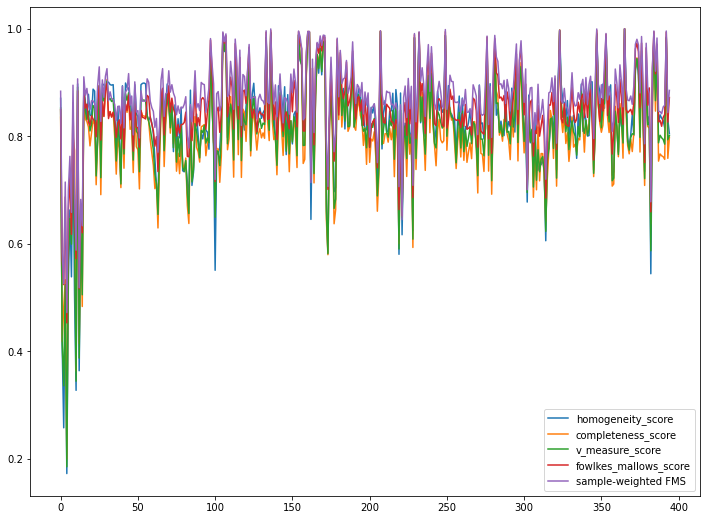

[INFO 06-30 23:13:20] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


     Generation Step Generation Model  Trial Index Trial Status  \
0                  0            Sobol            0    COMPLETED   
1                  0            Sobol            1    COMPLETED   
2                  0            Sobol            2    COMPLETED   
3                  0            Sobol            3    COMPLETED   
4                  0            Sobol            4    COMPLETED   
..               ...              ...          ...          ...   
395                1             GPEI          395    COMPLETED   
396                1             GPEI          396    COMPLETED   
397                1             GPEI          397    COMPLETED   
398                1             GPEI          398    COMPLETED   
399                1             GPEI          399    COMPLETED   

                                 Arm Parameterizations  
0    {'0_0': {'b0': 2.04, 'c0': 6.24, 'dl0': 12.25,...  
1    {'1_0': {'b0': 6.58, 'c0': 1.77, 'dl0': 10.47,...  
2    {'2_0': {'b0': 3.98

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.savefig(fn_result+"clustering_metric_evol.png")
plt.show()


print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

In [13]:
best_parameters, values = axc.get_best_parameters()

In [ ]:
#best_parameters = axc.get_trial_parameters(12) # in fact, worst parameters.
best_parameters = {'b0': 6.129207334451078,
                    'c0': 1.207514275741114,
                    'dl0': 13.0,
                    'dh0': 2.0380281794991895,
                    'b1': 6.129207334451078,
                    'c1': 1.207514275741114,
                    'dl1': 13.0,
                    'dh1': 2.0380281794991895,
                    'b2': 6.129207334451078,
                    'c2': 1.207514275741114,
                    'dl2': 13.0,
                    'dh2': 2.0380281794991895,
                    'b3': 6.129207334451078,
                    'c3': 1.207514275741114,
                    'dl3': 13.0,
                    'dh3': 2.0380281794991895,
                    'b4': 6.129207334451078,
                    'c4': 1.207514275741114,
                    'dl4': 13.0,
                    'dh4': 2.0380281794991895,
                    'b5': 6.129207334451078,
                    'c5': 1.207514275741114,
                    'dl5': 13.0,
                    'dh5': 2.0380281794991895,}

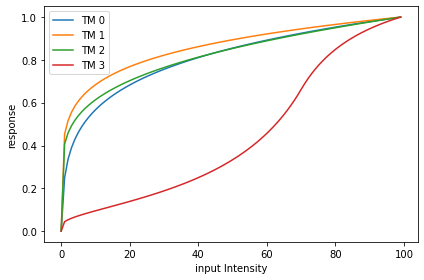

In [31]:
from astrobf.tmo import Mantiuk_Seidel

fig, ax = plt.subplots()

for i in range(ngroups):
    mapped = Mantiuk_Seidel(np.linspace(0,100,100),**mucl.ext_single_param(best_parameters, f"{i}"))
    
                            
    ax.plot( mapped / mapped.max(), label=f'TM {i}')
plt.legend()    
ax.set_xlabel("input Intensity")
ax.set_ylabel("response")
plt.tight_layout()
plt.savefig("TMOs_6G.png", dpi=144)

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [17]:
from astrobf import analysis

plt.close('all')

best_parameters, values = axc.get_best_parameters()

plist = []
for i in range(ngroups):
    plist.append(mucl.ext_single_param(best_parameters, f"{i}"))
    
result_list = []
for i in range(ngroups):
    result_list.append(mucl.get_morph(sub_gals, 
                                      plist[i], 
                                      np.where(subcat['label'] == i)[0],
                                      fields)
                                      )

# merge and sort
result_arr = np.concatenate(result_list)
result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
inds = result_arr['id'].searchsorted(subcat["ID"])
best_results = result_arr[inds]    


Full_exp.add_ttype(best_results, subcat)

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
Is every element matched?:  True


In [21]:
best_results = evaluate(best_parameters, cluster_method='SVM')

<ipython-input-20-b3f76d12bf14>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-20-b3f76d12bf14>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-20-b3f76d12bf14>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-20-b3f76d12bf14>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


In [18]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn import svm
from astrobf.utils.misc import struct_to_ndarray, select_columns


clf = svm.SVC(gamma=1, decision_function_shape='ovr')
compact = struct_to_ndarray(select_columns(best_results, fields))
labeler = partial(labeler, bins=this_bin)
labels = labeler(best_results)
clf.fit(compact, labels)

pred = clf.predict(compact)
metric = f1_score(pred, labels, average='macro')

In [75]:
log_loss([1,2,3,3], [3,3,2,1]) # log_loss는 predicted_probabilities 쌍이 필요함. pred.shape == (nsample by nclass)
# prob.를 주는 classifier는?? 

ValueError: y_true and y_pred contain different number of classes 3, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3]

In [19]:
f1_score(pred, labels, average='macro')

0.99215148576439305

(array([ 2826.,     0.,     0.,  2443.,     0.,     0.,  3450.,     0.,
            0.,   594.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <BarContainer object of 10 artists>)

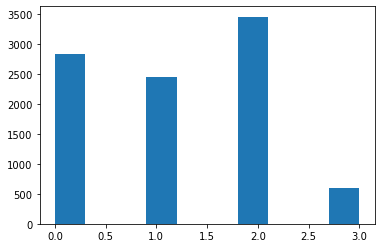

In [56]:
plt.hist(pred)
#plt.hist(labels)

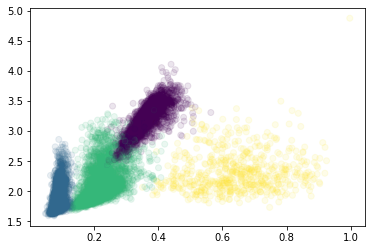

In [65]:
plt.scatter(compact[:,0], compact[:,2], c=pred, alpha=0.1)
plt.show()

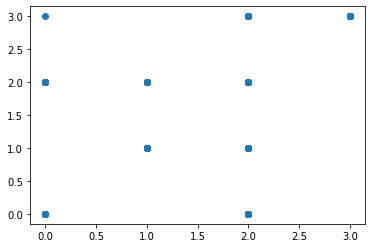

In [50]:
plt.scatter(pred, labels)
plt.show()

In [ ]:
plt.contou

In [ ]:
model.fit()

In [ ]:
# Classification


best_eval_metrics, best_classification = do_classification()

In [17]:
best_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin), subcat,
                                         fields=fields, 
                                         n_clusters=ngroups,
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
Is every element matched?:  True


9313


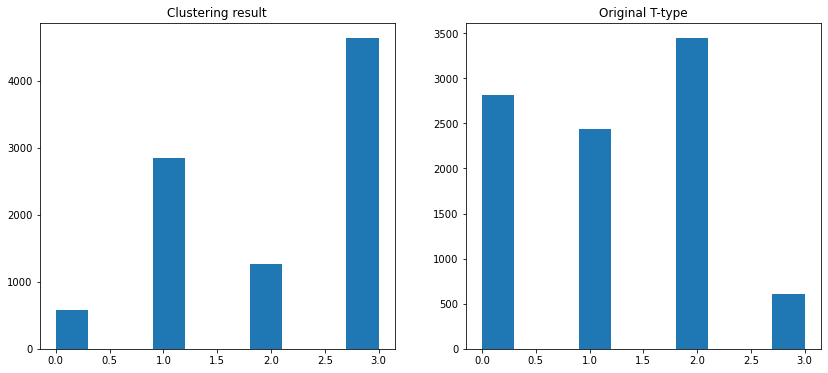

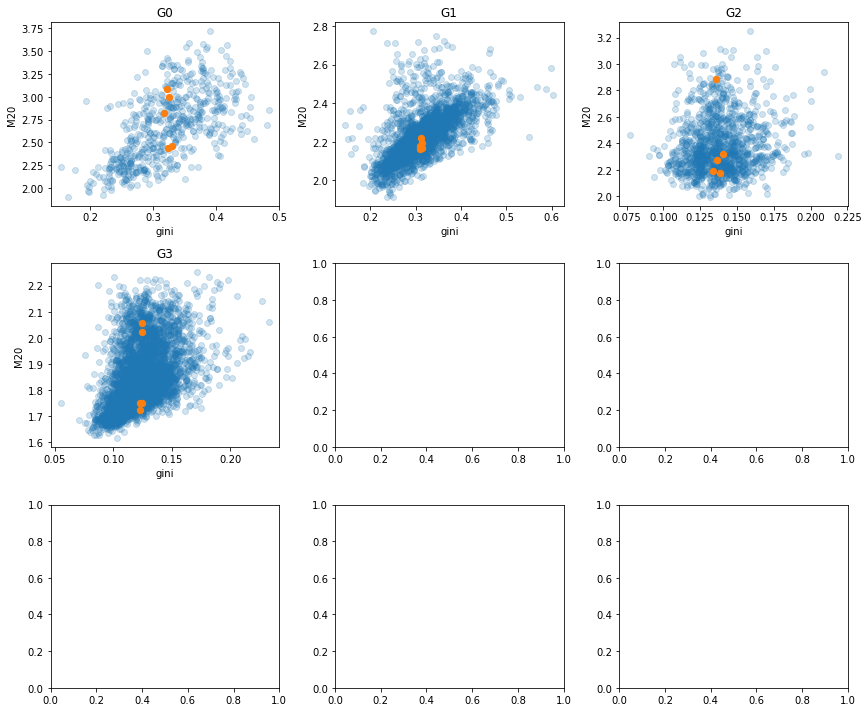

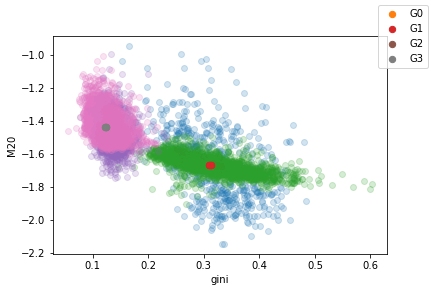

In [33]:
print(len(best_clustering.labels_))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].hist(best_clustering.labels_)
axs[0].set_title("Clustering result")
axs[1].hist(labeler(subcat, bins=this_bin, field='TT'))
axs[1].set_title("Original T-type")

plt.savefig(fn_result+"clustering_result_vs_original_pop.png")
plt.show()

# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(3,3)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['concentration'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['concentration'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.savefig(fn_result+"clustering_summary.png")
plt.show()

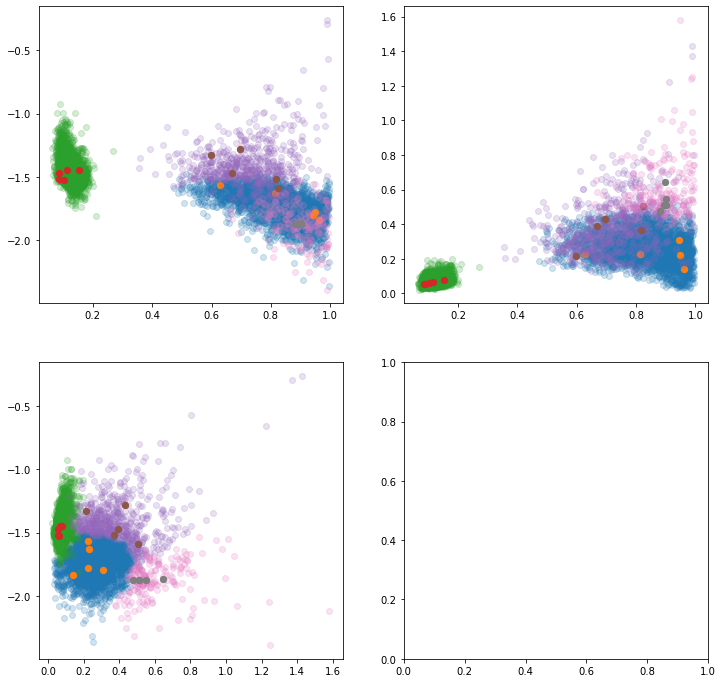

In [34]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,12)
axs = axs.ravel()
for i in range(ngroups):
    group = best_results[best_clustering.labels_ == i]
    axs[0].scatter(group['gini'], group['m20'], alpha=0.2)
    axs[0].scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")

    axs[1].scatter(group['gini'], group['asymmetry'], alpha=0.2)
    axs[1].scatter(group['gini'][t_ind], group['asymmetry'][t_ind], s=40, label=f"G{i}")

    axs[2].scatter(group['asymmetry'], group['m20'], alpha=0.2)
    axs[2].scatter(group['asymmetry'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")

plt.show()

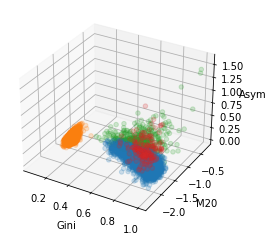

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#fig.set_size_inches(12,12)
for i in range(ngroups):
    group = best_results[best_clustering.labels_ == i]
    ax.scatter(group['gini'], group['m20'], group['asymmetry'], alpha=0.2)
    #ax.scatter(group['gini'][t_ind], group['m20'][t_ind], group['asymmetry'][t_ind], s=40, label=f"G{i}")

    #ax.scatter(group['gini'], group['asymmetry'], alpha=0.2)
    #ax.scatter(group['gini'][t_ind], group['asymmetry'][t_ind], s=40, label=f"G{i}")

    #axs[2].scatter(group['asymmetry'], group['m20'], alpha=0.2)
    #axs[2].scatter(group['asymmetry'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")

ax.set_xlabel("Gini")
ax.set_ylabel("M20")
ax.set_zlabel("Asym")
plt.show()

In [44]:
plt.close("all")

In [22]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [24]:
cmap = 'binary'
plt.set_cmap(cmap)
mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=exp_dir+fn_result+"groups_comp.png")

plt.set_cmap(cmap)
mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=True,
                          fn=exp_dir+fn_result+"groups_log.png")


<Figure size 432x288 with 0 Axes>

## Typical samples at incremental points 

### Get the 'incremental' points

<ipython-input-46-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-46-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-46-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-46-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-46-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-46-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



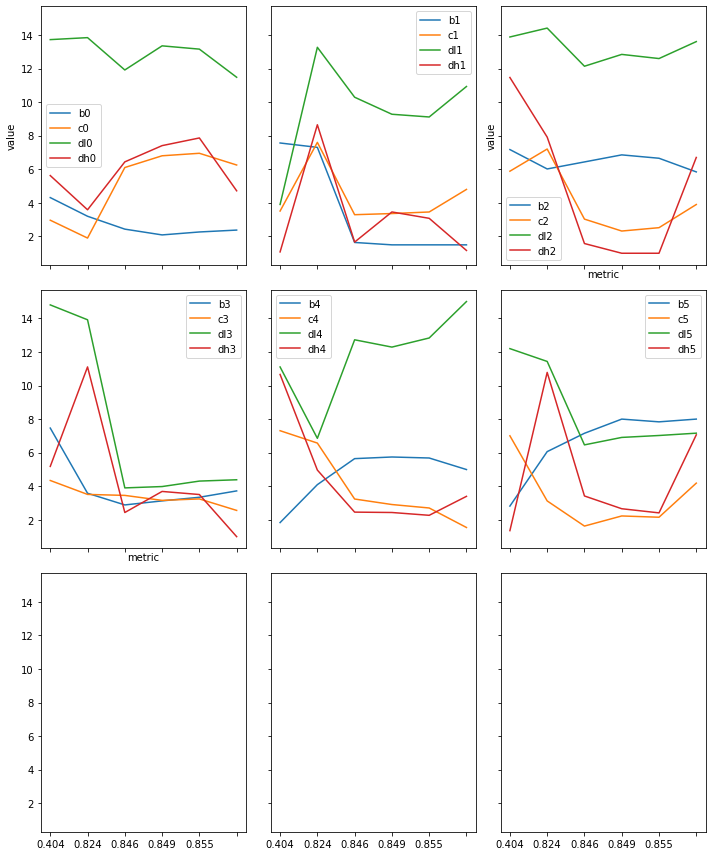

In [46]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(3,3, sharex=True, sharey=True)
fig.set_size_inches(10,12)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.savefig(fn_result+"param_evol.png")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [47]:
# Typicals defined above

clu_best = [best_results[best_clustering.labels_ == i] for i in range(ngroups)] 
typical_best_results = [analysis.utils.get_matched_result(best_results, 
                                               [gal['img_name'] for gal in tt]) for tt in typicals]

for i, this_params in enumerate(incr_params):
    
    plist = [mucl.ext_single_param(this_params, f"{i}") for i in range(ngroups)]
    
    mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=fn_result+f'typical_{i}.png',
                          suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

    this_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)
    if isinstance(this_results, str):
        print(i, this_params, this_results)
        continue
    Full_exp.add_ttype(this_results, subcat)

    eval_metrics, this_clustering = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                     fields=fields, 
                                     n_clusters=ngroups,
                                     return_cluster=True,
                                     cluster_method=cluster_method,
                                     eval_weight='area')

    typical_this_results = [(analysis.utils.get_matched_result(this_results, 
                                               [gal['img_name'] for gal in tt])) for tt in typicals]
    clu_this = [this_results[this_clustering.labels_ == i] for i in range(ngroups)] 
    mucl.plot_group_evals_w_centers(clu_best, 
                           typical_best_results,
                           clu_this, 
                           typical_this_results,
                           fn=fn_result+f"G_M{i}.png")

    mucl.plot_classification_vs_answer(this_results, clu_best, partial(labeler, bins=this_bin),
                                    fn=fn_result+f"current_in_best_color{i}.png")

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



0 {'b0': 4.3140138066373765, 'c0': 2.967609160579741, 'dl0': 13.721795273944736, 'dh0': 5.626111883670092, 'b1': 7.5658117975108325, 'c1': 3.5131095075048506, 'dl1': 3.905724987387657, 'dh1': 1.0790046844631433, 'b2': 7.173992343246937, 'c2': 5.885616240557283, 'dl2': 13.878627486526966, 'dh2': 11.465987687930465, 'b3': 7.465501278173178, 'c3': 4.344979745801538, 'dl3': 14.80080047249794, 'dh3': 5.182899435982108, 'b4': 1.83703941013664, 'c4': 7.309402645565569, 'dl4': 11.105029670521617, 'dh4': 10.65853613242507, 'b5': 2.820331302471459, 'c5': 7.005399528890848, 'dl5': 12.197025898844004, 'dh5': 1.3578878119587898} bad


KeyboardInterrupt: 

## Backup

In [17]:
from functools import partial

def evaluate_org(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(sub_gals, 
                                                          plist[i], 
                                                          np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}